# 시장 데이터와 기본 데이터: 소스와 기법
- 전통적 투자 전략
    - 주로 공개된 데이터 의존
    - f(`주식 기본 데이터`, `기업의 공시된 재무 데이터`, `산업 또는 매크로 데이터`)=`재무 모델`
    - 기술적 분석으로 주가와 거래량으로부터 계산된 지표를 사용해 시장 데이터에서 신호를 추출
- 현대 투자 전략
    - 머신러닝 알고리듬은 인간이 정의한 규칙이나 경험보다 효율적으로 시장 데이터와 기본 데이터를 활용
        - 3장의 대체 데이터와 결합할 때 더 효과적
        - 2장의 선형 모델에서 순환 신경망(RNN) 등의 ML 알고리듬이 어떻게 시장과 기본 데이터 거래에 유용한 신호를 생성하는지 설명
---
- 2장의 목표
> 1. 시장과 기본 데이터의 소스를 소개하고 이들이 만들어지는 환경(트레이딩 환경)을 어떻게 반영하는지 설명
    - 시장 데이터의 적절한 해석과 전략의 설계와 실행 및 현실적인 백테스트 시뮬레이션 구현에 중요
> 2. 파이썬으로 여러 소스로부터 트레이딩과 재무제표 데이터에 어떻게 접근하고 작업할 수 있는지

- 2장의 내용
    - **시장 데이터가 트레이딩 환경의 구조를 반영하는 방법**
    - **분 단위 빈도의 거러 데이터와 호가 데이터로 작업**
    - **나스닥 ITCH를 사용해 틱 데이터에서 주문 호가창을 재구성하는 방법**
    - **여러 가지 형태의 바를 이용해 틱 데이터를 요약하는 방법**
    - **XBRL(eXtensible Business Reporting Language)로 인코딩된 전자 공시 자료들을 다루는 방법**
    - **시장 데이터와 기본 데이터를 구문 분석하고 결합해 주가 이익 배율(P/E, Price-to-Earnings) 시계열을 만드는 방법**
    - **파이썬을 이용해 여러 시장 데이터와 기본 데이터 소스에 접근하는 방법**
---

## 시장 데이터는 시장 환경을 반영한다
- 시장 데이터
    - **금융 수단**에 대해 직접 또는 수많은 시장 중 하나의 시장에 있는 중개 기관을 통해 **주문을 내는 방법, 처리되는 방법, 수요와 공급의 매칭에 의해 가격이 설정되는 방법**의 산물
    - 따라서 시장 데이터는 **주문, 매매 체결 가격 형성을 통제하는 방법, 규제를 포함하는 트레이딩 장소의 제도적 환경**을 반영
    - 전 세계 시장에 대한 개요: [Harris](https://global.oup.com/ushe/product/trading-and-exchanges-9780195144703?cc=us&lang=en&) (2003)
    - 미국 시장에 대한 세부 사항: [Jones](https://www0.gsb.columbia.edu/faculty/cjones/papers/2018.08.31%20US%20Equity%20Market%20Data%20Paper.pdf) (2018)

- 알고리듬 트레이더
    - ML을 포함한 알고리듬을 사용해 매수와 매도 주문의 흐름과 그 결과로 형성되는 거래량과 가격을 통계량을 분석해 **트레이드 신호를 추출** -> **수요 공급 동태 또는 특정 시장 참여자의 형태에 대한 이해도**를 높임
---
**백테스트 동안 트레이딩 전략의 시뮬레이션에 영향을 주는 제도적 특성**들을 살펴보고,     
이러한 환경, 즉 **나스닥에 의해 생성되는 실제 틱 데이터를 작업**한다.

---

### 시장 미시 구조: 기본 지식
- 제도적 환경이 트레이딩 과정에 어떻게 영향을 주고, 
- **가격 발견, 매수-매도 호가 스프레드와 호가, 일중 트레이딩 행태와 거래 비용** 같은 결과를 어떻게 형성하는지 연구

### 트레이딩 방법: 여러 종류의 주문
- 주문의 종류
    - **시장가 주문(market order)**: 주문이 거래 플랫폼에 도달하는 순간 가능한 시장 가격으로 즉시 체결을 보장
    - **지정가 주문(limit order)**
        - 매도 지정가 주문: 시장 가격이 지정가보다 큰 경우에만 체결
        - 매수 지정가 주문: 시장 가격이 지정가보다 작은 경우에만 체결
    - **스탑 주문(stop order)**
        - 매수 스탑 주문: 시장 가격이 지정한 가격보다 큰 경우에만 활성화*(공매도 손실 방지로 사용 가능)*
        - 매도 수탑 주문: 시장 가격이 저정한 가격보다 작은 경우에만 활성화
        - *스탑 주문도 지정가를 가질 수 있음*

- 주문의 여러 조건
    - **모두 아니면 취소(All or none) 주문**: 부분 체결 방지
    - **즉시 모두 체결 아니면 취소(Fill or Kill) 주문**: 부분 체결을 방지하지만, 즉시 체결되지 않으면 취소
    - **즉시 체결 아니면 취소(immediate or cancel) 주문**: 매매 가능한 주식수를 즉시 매수 또는 매도하고 나머지는 취소
    - **재량(Not-held) 주문**: 브로커가 체결의 시점과 가격을 결정
    - **시가 또는 종가 시장(market on open/close) 주문**: 시장의 개장 시점이나 종료 시점 또는 그 근처에서 체결, 부분 체결 허용

### 트레이딩 장소: 거래소에서 다크풀까지
- 나스닥에는 다수의 시장 조성자(market maker)가 주식 거래를 용이하게 함
- 오늘날 트레이딩은 파편화됨
    - 미국에서는 2개의 주요 베뉴 대신 거래소와 전자통신망(ECN) 같은 (비규제화된) 대체 거래 시스템(ATS)을 포함한 13개가 넘는 트레이딩 베뉴가 존재
        - ATS는 트레이더가 익명으로 거래를 실행할 수 있는 수십 개의 다크풀을 포함

## 고빈도 데이터로 작업
- 두 범주의 시장 데이터가 Reg NMS하에 미국 증권거래소에서 거래되는 수천 개의 기업을 커버
    - 통합 피드는 각 트레이딩 베뉴로부터의 거래와 호가 데이터 결합
    - 각 개별 거래소는 그 특정 베뉴에 대한 추가 활동 정보를 가진 독점적 상품 공급
---
- 나스닥에 의해 제공되는 틱별 기반으로 주문, 거래 및 결과 가격의 실제 흐름을 나타내는 **독점적 주문 흐름 데이터**를 제시
- 불규칙한 간격으로 도달하는 **연속 흐름의 데이터**를 고정된 기간의 바로 정규화
- 통한된 거래와 호가 정보를 포함하는 AlgoSeek의 **주식 분바 데이터** 소개
---

### 나스닥 주문 호가창으로 작업
시장 데이터의 가장 중요한 소스는 호가창이며, 모든 트레이딩 활동을 반영하여 종일 실시간 업데이트됨

- 미국 주식시장의 3개의 층으로 호가를 제공:
    - 레벨 1(L1): 온라인 소스로부터 가능한 **실시간 매수와 매도 호가 정보**
    - 레벨 2(L2): 특정 시장 조성자에 의한 **매수 및 매도 호가**와 함께 주어진 주식의 유동성에 대한 더 나은 통찰을 위해 **최근 거래의 크기와 시간에 대한 정보**를 더함
    - 레벨 3(L3): **호가를 넣거나 변경**할 수 있고 **주문을 실행하고 거래를 확인**할 수 있는 능력을 더함(시장 조성자와 거래소 회원 기업만 접근 가능)

> 트레이딩 활동은 **매매에 관련된 수많은 메시지**에 반영되며,    
이 메시지는 **전자 금융 정보 교환(FIX) 통신 프로토콜이나 거래소 고유의 교환 프로토콜**을 준수

### FIX 프로토콜을 활용한 거래의 통신
- FIX 프로토콜: 거래소, 은행, 브로커, 정산소와 기타 시장 참여자 간의 거래 체결 이전과 거래 체결 중 소통을 위한 메시징 표준
    - 일괄 처리(STP, Straight-Trough Processing)를 지원하는 사후 거래 시스템으로 발전
    - 거래소는 FIX 메시지의 접근을 제공하여, 알고리듬 트레이더 들이 실시간 데이터 피드를 파스(parse)해 시장 행태를 추적하고, 파악하여 다음 행태를 예상하도록 함
- 메시지 시퀀스: 호가창을 재구성할 수 있게 함
    - FIX 세션은 TCP 층에서 지원
    - 프로코톨은 파이프 분리된 키-값의 쌍과 태그 기반의 FIXML 구문을 지원
- FIX 메시지를 형성하고 파싱하는데 사용할 수 있는 파이썬 소스의 FIX 구현이 공개됨

### 나스닥 토탈뷰-잇치 데이터 피드
FIX의 시장 점유율이 압도적이지만, 거래소만의 프로토콜을 제공함
- **나스닥**은 개별 주문을 추적할 수 있는 **[토탈뷰-잇치(TotalView-ITCH) 직접 데이터 피드 프로토콜](http://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf)**을 제공
    - 데이터의 과거 기록은 특정 증권에 대해 활성화된 지정가 주문을 추적하는 호가창을 재구성할 수 있게 함

- **호가창**: 가격별로 **매수 또는 매도 호가되는 주식의 수**를 보여줌으로써 장중 **시장의 깊이(market depth)**를 알려줌
    - 시장의 깊이: 유동성과 대규모 시장가 주문의 잠재적 가격 영향을 파악하는 핵심 지표

시장가와 지정가 주문을 매칭하는 것 이외에도 나스닥은 개장과 종장 시 수많은 거래를 체결하는 옥션이나 크로스를 운영한다.

#### 이진 주문 메시지의 파싱
ITCH v5.0 사양은 시스템 이벤트, 주식 특성, 한계 주문의 배치 및 수정, 거래 실행과 관련된 20개 이상의 메시지 유형을 선언한다.    
또한 오픈 및 종료 크로스 이전의 순 주문 불균형에 대한 정보도 포함한다.

나스닥은 여러 달 동안의 일별 바이너리 파일 샘플을 제공한다.    
이 장의 GitHub 저장소에는 ITCH 메시지의 샘플 파일을 파싱하고 실행된 거래와 주문 북을 재구성하는 방법을 보여주는 `build_order_book.ipynb` 노트북이 포함된다.

다음 표는 책에서 사용된 샘플 파일(2018년 3월 29일 기준)에서 가장 일반적인 메시지 유형의 빈도를 보여준다.

| 메시지 유형 | 주문 북 영향                                                                  | 메시지 수    |
|:----------:|------------------------------------------------------------------------------|-------------:|
|     A      | 새로운 미지정 한계 주문                                                       | 136,522,761 |
|     D      | 주문 취소                                                                     | 133,811,007 |
|     U      | 주문 취소 및 대체                                                             |  21,941,015 |
|     E      | 전체 또는 부분 실행; 동일한 원래 주문에 대해 여러 메시지일 수 있음            |   6,687,379 |
|     X      | 부분 취소 후 수정                                                             |   5,088,959 |
|     F      | 속성이 있는 주문 추가                                                          |   2,718,602 |
|     P      | 거래 메시지 (크로스가 아님)                                                    |   1,120,861 |
|     C      | 처음 표시 가격과 다른 가격에서 전체 또는 부분 실행                              |     157,442 |
|     Q      | 크로스 거래 메시지                                                            |      17,233 |

각 메시지에 대해 사양은 구성 요소와 해당하는 길이 및 데이터 유형을 설명합니다:

|         이름         | 오프셋 | 길이 |    값    |                                참고                                |
|----------------------|---------|------|----------|-------------------------------------------------------------------|
|    메시지 유형       |    0    |  1   |    S     |                     시스템 이벤트 메시지                         |
|   주식 위치     |    1    |  2   | Integer  |                                항상 0                             |
|   추적 번호          |    3    |  2   | Integer  |                  나스닥 내부 추적 번호                          |
|     타임스탬프       |    5    |  6   | Integer  |                 자정 이후 나노초                               |
| 주문 참조 번호     |   11    |  8   | Integer  |       주문 수신 시간에 할당된 고유한 참조 번호                 |
| 매수/매도 표시     |   19    |  1   |  Alpha   |               추가되는 주문의 유형. B = 매수 주문, S = 매도 주문 |
|      주식 수량      |   20    |  4   | Integer  |         주문 북에 추가되는 주문과 관련된 총 주식 수량           |
|        주식         |   24    |  8   |  Alpha   |               오른쪽 공백으로 채워진 주식 기호                 |
|        주가         |   32    |  4   | Price(4) |  새로운 주문의 디스플레이 가격. 필드 처리 노트 참조          |
|      기여도           |   36    |  4   |  Alpha   |               입력된 주문과 관련된 나스닥 시장 참가자 식별자  |

---
노트북 `01_build_itch_order_book`, `02_rebuild_nasdaq_order_book` 및 `03_normalize_tick_data`에는 다음을 포함하는 코드가 있습니다.

- 나스닥 Total View 샘플 틱 데이터 다운로드
- 바이너리 소스 데이터에서 메시지 파싱
- 특정 주식에 대한 주문 북 재구성
- 주문 플로우 데이터 시각화
- 틱 데이터 정규화

코드는 최신 나스닥 샘플 파일(2019년 3월 27일 기준)을 사용하도록 업데이트되었습니다.

---

#### 01_parse_itch_order_flow_messages.ipynb

##### Nasdaq TotalView-ITCH Order Book data

While FIX has a dominant large market share, exchanges also offer native protocols. The Nasdaq offers a [TotalView ITCH direct data-feed protocol](http://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHspecification.pdf) that allows subscribers to track 
individual orders for equity instruments from placement to execution or cancellation.

As a result, it allows for the reconstruction of the order book that keeps track of the list of active-limit buy and sell orders for a specific security or financial instrument. The order book reveals the market depth throughout the day by listing the number of shares being bid or offered at each price point. It may also identify the market participant responsible for specific buy and sell orders unless it is placed anonymously. Market depth is a key indicator of liquidity and the potential price impact of sizable market orders. 

The ITCH v5.0 specification declares over 20 message types related to system events, stock characteristics, the placement and modification of limit orders, and trade execution. It also contains information about the net order imbalance before the open and closing cross.

##### Imports

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%matplotlib inline
import gzip
import shutil
from struct import unpack
from collections import namedtuple, Counter, defaultdict
from pathlib import Path
from urllib.request import urlretrieve
from urllib.parse import urljoin
from datetime import timedelta
from time import time

import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')

In [ ]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>5.2f}'

##### Get NASDAQ ITCH Data from FTP Server

The Nasdaq offers [samples](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/) of daily binary files for several months. 

We are now going to illustrates how to parse a sample file of ITCH messages and reconstruct both the executed trades and the order book for any given tick.

The data is fairly large and running the entire example can take a lot of time and require substantial memory (16GB+). Also, the sample file used in this example may no longer be available because NASDAQ occasionaly updates the sample files.

The following table shows the frequency of the most common message types for the sample file date March 29, 2018:

| Name                    | Offset  | Length  | Value      | Notes                                                                                |
|-------------------------|---------|---------|------------|--------------------------------------------------------------------------------------|
| Message Type            | 0       | 1       | S          | System Event Message                                                                 |
| Stock Locate            | 1       | 2       | Integer    | Always 0                                                                             |
| Tracking Number         | 3       | 2       | Integer    | Nasdaq internal tracking number                                                      |
| Timestamp               | 5       | 6       | Integer    | Nanoseconds since midnight                                                           |
| Order Reference Number  | 11      | 8       | Integer    | The unique reference number assigned to the new order at the time of receipt.        |
| Buy/Sell Indicator      | 19      | 1       | Alpha      | The type of order being added. B = Buy Order. S = Sell Order.                        |
| Shares                  | 20      | 4       | Integer    | The total number of shares associated with the order being added to the book.        |
| Stock                   | 24      | 8       | Alpha      | Stock symbol, right padded with spaces                                               |
| Price                   | 32      | 4       | Price (4)  | The display price of the new order. Refer to Data Types for field processing notes.  |
| Attribution             | 36      | 4       | Alpha      | Nasdaq Market participant identifier associated with the entered order               |

- **Set Data paths**

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [ ]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'

You can find several sample files on the [NASDAQ server](https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/).

The HTTPS address, filename and corresponding date used in this example:

In [ ]:
HTTPS_URL = 'https://emi.nasdaq.com/ITCH/Nasdaq%20ITCH/'
SOURCE_FILE = '10302019.NASDAQ_ITCH50.gz'

- URL updates

NASDAQ updates the files occasionally so that the SOURCE_FILE changes. If the above gives an error, navigate to the HTTPS_URL using your browser, and check for new files. As of September 2021, the listed files include:

- 01302020.NASDAQ_ITCH50.gz
- 12302019.NASDAQ_ITCH50.gz
- 10302019.NASDAQ_ITCH50.gz
- 08302019.NASDAQ_ITCH50.gz
- 07302019.NASDAQ_ITCH50.gz
- 03272019.NASDAQ_ITCH50.gz
- 01302019.NASDAQ_ITCH50.gz
- 12282018.NASDAQ_ITCH50.gz


- Download & unzip

In [ ]:
def may_be_download(url):
    """Download & unzip ITCH data if not yet available"""
    if not data_path.exists():
        print('Creating directory')
        data_path.mkdir()
    else: 
        print('Directory exists')

    filename = data_path / url.split('/')[-1]        
    if not filename.exists():
        print('Downloading...', url)
        urlretrieve(url, filename)
    else: 
        print('File exists')        

    unzipped = data_path / (filename.stem + '.bin')
    if not unzipped.exists():
        print('Unzipping to', unzipped)
        with gzip.open(str(filename), 'rb') as f_in:
            with open(unzipped, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
    else: 
        print('File already unpacked')
    return unzipped

This will download 5.1GB data that unzips to 12.9GB (this may vary depending on the file, see 'url updates' below).

In [ ]:
file_name = may_be_download(urljoin(HTTPS_URL, SOURCE_FILE))
date = file_name.name.split('.')[0]

Directory exists
File exists
File already unpacked


##### ITCH Format Settings

- **The `struct` module for binary data**

The ITCH tick data comes in binary format. Python provides the `struct` module (see [docs](https://docs.python.org/3/library/struct.html)) to parse binary data using format strings that identify the message elements by indicating length and type of the various components of the byte string as laid out in the specification.

From the docs:

> This module performs conversions between Python values and C structs represented as Python bytes objects. This can be used in handling binary data stored in files or from network connections, among other sources. It uses Format Strings as compact descriptions of the layout of the C structs and the intended conversion to/from Python values.

Let's walk through the critical steps to parse the trading messages and reconstruct the order book:

- **Defining format strings**

The parser uses format strings according to the following formats dictionaries:

In [ ]:
event_codes = {'O': 'Start of Messages',
               'S': 'Start of System Hours',
               'Q': 'Start of Market Hours',
               'M': 'End of Market Hours',
               'E': 'End of System Hours',
               'C': 'End of Messages'}

In [ ]:
encoding = {'primary_market_maker': {'Y': 1, 'N': 0},
            'printable'           : {'Y': 1, 'N': 0},
            'buy_sell_indicator'  : {'B': 1, 'S': -1},
            'cross_type'          : {'O': 0, 'C': 1, 'H': 2},
            'imbalance_direction' : {'B': 0, 'S': 1, 'N': 0, 'O': -1}}

- ITCH 파서는 message_types.xlsx로 제공되는 메시지 사양에 의존
- 이는 formats 딕셔너리에 따라 문자열 포맷을 조합

In [ ]:
formats = {
    ('integer', 2): 'H',  # int of length 2 => format string 'H'
    ('integer', 4): 'I',
    ('integer', 6): '6s',  # int of length 6 => parse as string, convert later
    ('integer', 8): 'Q',
    ('alpha',   1): 's',
    ('alpha',   2): '2s',
    ('alpha',   4): '4s',
    ('alpha',   8): '8s',
    ('price_4', 4): 'I',
    ('price_8', 8): 'Q',
}

##### Create message specs for binary data parser

The ITCH parser relies on message specifications that we create in the following steps.

- Load Message Types

The file `message_types.xlxs` contains the message type specs as laid out in the [documentation](https://www.nasdaqtrader.com/content/technicalsupport/specifications/dataproducts/NQTVITCHSpecification.pdf)

In [ ]:
message_data = (pd.read_excel('https://github.com/FE-Quant-Study/Machine-Learning-for-Algorithmic-Trading-Second-Edition/raw/master/02_market_and_fundamental_data/01_NASDAQ_TotalView-ITCH_Order_Book/message_types.xlsx',
                              sheet_name='messages')
                .sort_values('id')
                .drop('id', axis=1))

In [ ]:
message_data.head()

,Name,Offset,Length,Value,Notes
0,Message Type,0,1,S,System Event Message
1,Stock Locate,1,2,Integer,Always 0
2,Tracking Number,3,2,Integer,Nasdaq internal tracking number
3,Timestamp,5,6,Integer,Nanoseconds since midnight
4,Event Code,11,1,Alpha,See System Event Codes below


- **Basic Cleaning**

The function `clean_message_types()` just runs a few basic string cleaning steps.

In [ ]:
def clean_message_types(df):
    df.columns = [c.lower().strip() for c in df.columns]
    df.value = df.value.str.strip()
    df.name = (df.name
               .str.strip() # remove whitespace
               .str.lower()
               .str.replace(' ', '_')
               .str.replace('-', '_')
               .str.replace('/', '_'))
    df.notes = df.notes.str.strip()
    df['message_type'] = df.loc[df.name == 'message_type', 'value']
    return df

In [ ]:
message_types = clean_message_types(message_data)

- **Get Message Labels**

We extract message type codes and names so we can later make the results more readable.

In [ ]:
message_labels = (message_types.loc[:, ['message_type', 'notes']]
                  .dropna()
                  .rename(columns={'notes': 'name'}))
message_labels.name = (message_labels.name
                       .str.lower()
                       .str.replace('message', '')
                       .str.replace('.', '')
                       .str.strip().str.replace(' ', '_'))
# message_labels.to_csv('message_labels.csv', index=False)
message_labels.head()

,message_type,name
0,S,system_event
5,R,stock_directory
23,H,stock_trading_action
31,Y,reg_sho_short_sale_price_test_restricted_indic...
37,L,market_participant_position


- Finalize specification details

Each message consists of several fields that are defined by offset, length and type of value. The `struct` module will use this format information to parse the binary source data.

In [ ]:
message_types.message_type = message_types.message_type.ffill()
message_types = message_types[message_types.name != 'message_type']
message_types.value = (message_types.value
                       .str.lower()
                       .str.replace(' ', '_')
                       .str.replace('(', '')
                       .str.replace(')', ''))
message_types.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 1 to 172
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   name          152 non-null    object
 1   offset        152 non-null    int64 
 2   length        152 non-null    int64 
 3   value         152 non-null    object
 4   notes         152 non-null    object
 5   message_type  152 non-null    object
dtypes: int64(2), object(4)
memory usage: 8.3+ KB


In [ ]:
message_types.head()

,name,offset,length,value,notes,message_type
1,stock_locate,1,2,integer,Always 0,S
2,tracking_number,3,2,integer,Nasdaq internal tracking number,S
3,timestamp,5,6,integer,Nanoseconds since midnight,S
4,event_code,11,1,alpha,See System Event Codes below,S
6,stock_locate,1,2,integer,Locate Code uniquely assigned to the security ...,R


Optionally, persist/reload from file:
- ITCH 사양을 얻고 (type, length)의 튜플로 포맷

In [ ]:
message_types.to_csv('message_types.csv', index=False)

In [ ]:
message_types = pd.read_csv('message_types.csv')

The parser translates the message specs into format strings and `namedtuples` that capture the message content. First, we create `(type, length)` formatting tuples from ITCH specs:

In [ ]:
message_types.loc[:, 'formats'] = (message_types[['value', 'length']]
                            .apply(tuple, axis=1).map(formats))

Then, we extract formatting details for alphanumerical fields
- 알파 필드의 포맷

In [ ]:
alpha_fields = message_types[message_types.value == 'alpha'].set_index('name')
alpha_msgs = alpha_fields.groupby('message_type')
alpha_formats = {k: v.to_dict() for k, v in alpha_msgs.formats}
alpha_length = {k: v.add(5).to_dict() for k, v in alpha_msgs.length}

We generate message classes as named tuples and format strings
- 메시지 클래스를 name tuple과 문자열 포맷으로 생성

In [ ]:
message_fields, fstring = {}, {}
for t, message in message_types.groupby('message_type'):
    message_fields[t] = namedtuple(typename=t, field_names=message.name.tolist())
    fstring[t] = '>' + ''.join(message.formats.tolist())

In [ ]:
alpha_fields.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45 entries, event_code to price_variation_indicator
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   offset        45 non-null     int64 
 1   length        45 non-null     int64 
 2   value         45 non-null     object
 3   notes         45 non-null     object
 4   message_type  45 non-null     object
 5   formats       45 non-null     object
dtypes: int64(2), object(4)
memory usage: 2.5+ KB


In [ ]:
alpha_fields.head()

,offset,length,value,notes,message_type,formats
name,,,,,,
event_code,11,1,alpha,See System Event Codes below,S,s
stock,11,8,alpha,Denotes the security symbol for the issue in t...,R,8s
market_category,19,1,alpha,Indicates Listing market or listing market tie...,R,s
financial_status_indicator,20,1,alpha,"For Nasdaq listed issues, this field indicates...",R,s
round_lots_only,25,1,alpha,Indicates if Nasdaq system limits order entry ...,R,s


Fields of `alpha` type (alphanumeric) require post-processing as defined in the `format_alpha` function:
- 알파 타입의 필드는 format_alpha 함수에 정의된 후처리를 요함

In [ ]:
def format_alpha(mtype, data):
    """Process byte strings of type alpha"""

    for col in alpha_formats.get(mtype).keys():
        if mtype != 'R' and col == 'stock':
            data = data.drop(col, axis=1)
            continue
        data.loc[:, col] = data.loc[:, col].str.decode("utf-8").str.strip()
        if encoding.get(col):
            data.loc[:, col] = data.loc[:, col].map(encoding.get(col))
    return data

##### Process Binary Message Data

The binary file for a single day contains over 350,000,000 messages worth over 12 GB.

In [ ]:
def store_messages(m):
    """Handle occasional storing of all messages"""
    with pd.HDFStore(itch_store) as store:
        for mtype, data in m.items():
            # convert to DataFrame
            data = pd.DataFrame(data)

            # parse timestamp info
            data.timestamp = data.timestamp.apply(int.from_bytes, byteorder='big')
            data.timestamp = pd.to_timedelta(data.timestamp)

            # apply alpha formatting
            if mtype in alpha_formats.keys():
                data = format_alpha(mtype, data)

            s = alpha_length.get(mtype)
            if s:
                s = {c: s.get(c) for c in data.columns}
            dc = ['stock_locate']
            if m == 'R':
                dc.append('stock')
            try:
                store.append(mtype,
                         data,
                         format='t',
                         min_itemsize=s,
                         data_columns=dc)
            except Exception as e:
                print(e)
                print(mtype)
                print(data.info())
                print(pd.Series(list(m.keys())).value_counts())
                data.to_csv('data.csv', index=False)
                return 1
    return 0

In [ ]:
messages = defaultdict(list)
message_count = 0
message_type_counter = Counter()

The script appends the parsed result iteratively to a file in the fast HDF5 format using the `store_messages()` function we just defined to avoid memory constraints (see last section in chapter 2 for more on this format).

The following code processes the binary file and produces the parsed orders stored by message type:
- 이진 파일을 처리하고 메시지 타입별로 저장된 파싱된 주문을 생성

In [ ]:
# 메모리 제한 설정

import datetime

start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)

        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])

        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9

            # Check if the time is between 9:00 and 12:00
            event_time = datetime.datetime.fromtimestamp(seconds)
            if event_time.time() >= datetime.time(9) and event_time.time() <= datetime.time(12):
                print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
                print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
                if message.event_code.decode('ascii') == 'C':
                    store_messages(messages)
                    break

        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

        # Check if memory limit exceeded
        if message_count >= 150000000:
            print('Reached the end of the available data. Stopping execution.')
            break

print('Duration:', format_time(time() - start))


 Start of Market Hours
	09:30:00.00	  10,559,279
	09:43:05.96	  25,000,000	00:01:42.74
	10:06:51.80	  50,000,000	00:06:28.74
	10:38:32.64	  75,000,000	00:10:49.17
	11:16:28.93	 100,000,000	00:15:30.66
	11:57:00.64	 125,000,000	00:19:53.57
	12:42:10.74	 150,000,000	00:24:41.77
Reached the end of the available data. Stopping execution.
Duration: 00:27:22.40


In [ ]:
'''start = time()
with file_name.open('rb') as data:
    while True:

        # determine message size in bytes
        message_size = int.from_bytes(data.read(2), byteorder='big', signed=False)
        
        # get message type by reading first byte
        message_type = data.read(1).decode('ascii')        
        message_type_counter.update([message_type])

        # read & store message
        try:
            record = data.read(message_size - 1)
            message = message_fields[message_type]._make(unpack(fstring[message_type], record))
            messages[message_type].append(message)
        except Exception as e:
            print(e)
            print(message_type)
            print(record)
            print(fstring[message_type])
        
        # deal with system events
        if message_type == 'S':
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            print('\n', event_codes.get(message.event_code.decode('ascii'), 'Error'))
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}')
            if message.event_code.decode('ascii') == 'C':
                store_messages(messages)
                break
        message_count += 1

        if message_count % 2.5e7 == 0:
            seconds = int.from_bytes(message.timestamp, byteorder='big') * 1e-9
            d = format_time(time() - start)
            print(f'\t{format_time(seconds)}\t{message_count:12,.0f}\t{d}')
            res = store_messages(messages)
            if res == 1:
                print(pd.Series(dict(message_type_counter)).sort_values())
                break
            messages.clear()

print('Duration:', format_time(time() - start))'''


 Start of Messages
	03:02:31.65	           0

 Start of System Hours
	04:00:00.00	     241,258

 Start of Market Hours
	09:30:00.00	   9,559,279
	09:44:09.23	  25,000,000	00:01:36.96
	10:07:45.15	  50,000,000	00:05:55.21
	10:39:56.24	  75,000,000	00:10:15.61
	11:18:09.64	 100,000,000	00:14:29.57
	11:58:35.35	 125,000,000	00:18:46.27
	12:44:20.61	 150,000,000	00:23:46.78


##### Summarize Trading Day

- **Trading Message Frequency**

In [ ]:
counter = pd.Series(message_type_counter).to_frame('# Trades')
counter['Message Type'] = counter.index.map(message_labels.set_index('message_type').name.to_dict())
counter = counter[['Message Type', '# Trades']].sort_values('# Trades', ascending=False)
counter

,Message Type,# Trades
A,add_order_no_mpid_attribution,65262174
D,order_delete,62218501
U,order_replace,13284179
E,order_executed,3244190
X,order_cancel,2551279
F,add_order_mpid_attribution,1087260
I,noii,1072626
P,trade,725755
L,market_participant_position,429415
C,order_executed_with_price,62328


In [ ]:
with pd.HDFStore(itch_store) as store:
    store.put('summary', counter)

- **Top Equities by Traded Value**
- 9,500 종목의 모든 주식에 대한 트레이딩 활동의 요약

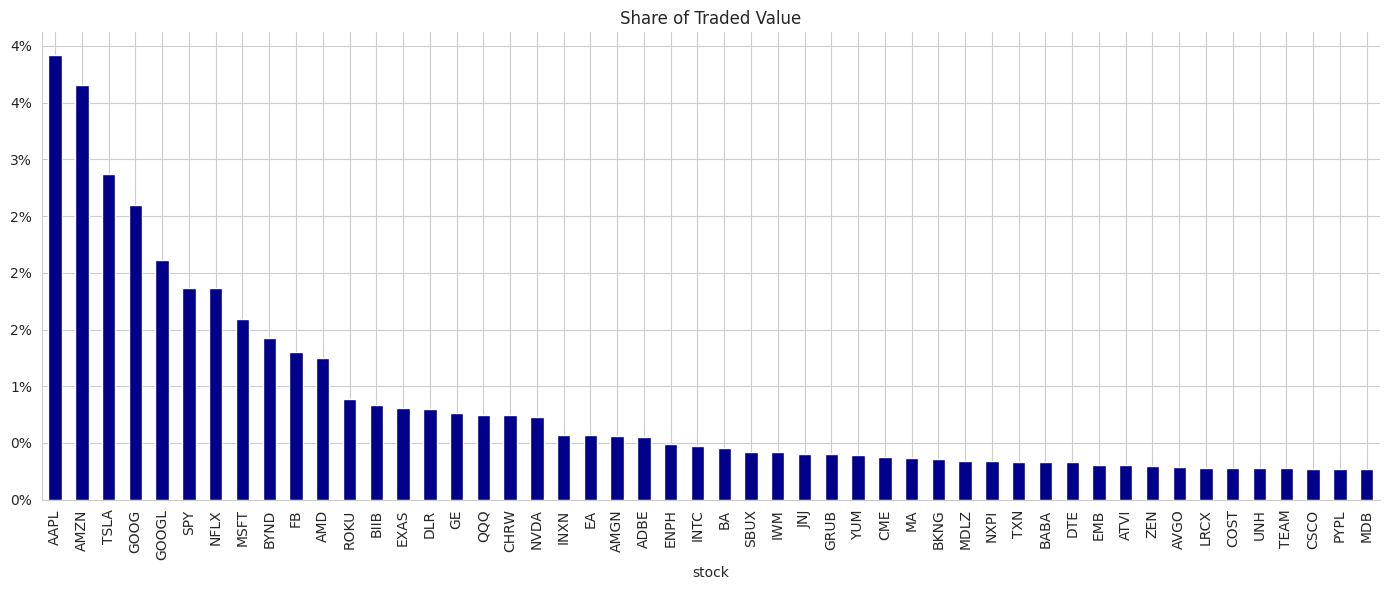

In [ ]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)
trades['value_share'] = trades.value.div(trades.value.sum())

trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='Share of Traded Value')

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
sns.despine()
plt.tight_layout()

#### 모든 거래와 호가창의 재구성 방법
파싱된 메시지로 주어진 날의 주문 흐름을 재구축할 수 있다.
'R' 메시지 타입은 주어진 날에 거래된 신규 상장(IPO)과 거래 제한 종목 정보를 포함한 모든 주식의 리스트를 보유한다.

장중 내내 신규 주문이 더해지고 체계되고 취소된 주문이 호가창에서 제외된다. 이전에 낸 주문을 참조하는 메시지를 적절히 고려하고자 여러 날에 걸쳐 호가창을 추적할 필요가 있을 수 있다.



#### 02_rebuild_nasdaq_order_book.ipynb

###### Working with Order Book Data: NASDAQ ITCH

The primary source of market data is the order book, which is continuously updated in real-time throughout the day to reflect all trading activity. Exchanges typically offer this data as a real-time service and may provide some historical data for free.

The trading activity is reflected in numerous messages about trade orders sent by market participants. These messages typically conform to the electronic Financial Information eXchange (FIX) communications protocol for real-time exchange of securities transactions and market data or a native exchange protocol. 

###### Imports

In [ ]:
from pathlib import Path
from collections import Counter
from datetime import timedelta
from datetime import datetime
from time import time

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')

In [ ]:
def format_time(t):
    """Return a formatted time string 'HH:MM:SS
    based on a numeric time() value"""
    m, s = divmod(t, 60)
    h, m = divmod(m, 60)
    return f'{h:0>2.0f}:{m:0>2.0f}:{s:0>2.0f}'

- **Set Data paths**

We will store the download in a `data` subdirectory and convert the result to `hdf` format (discussed in the last section of chapter 2).

In [ ]:
data_path = Path('data') # set to e.g. external harddrive
itch_store = str(data_path / 'itch.h5')
order_book_store = data_path / 'order_book.h5'
date = '10302019'

###### Build Order Book

In [ ]:
stock = 'AAPL'
order_dict = {-1: 'sell', 1: 'buy'}

The parsed messages allow us to rebuild the order flow for the given day. The 'R' message type contains a listing of all stocks traded during a given day, including information about initial public offerings (IPOs) and trading restrictions.

Throughout the day, new orders are added, and orders that are executed and canceled are removed from the order book. The proper accounting for messages that reference orders placed on a prior date would require tracking the order book over multiple days, but we are ignoring this aspect here.

- **Get all messages for given stock**

The `get_messages()` function illustrates how to collect the orders for a single stock that affects trading (refer to the ITCH specification for details about each message):


get_messages() 함수는 트레이딩에 영향을 주는 단일 주식에 대한 주문을 어떻게 수집하는지 보여준다.

In [ ]:
def get_messages(date, stock=stock):
    """Collect trading messages for given stock"""
    with pd.HDFStore(itch_store) as store:
        stock_locate = store.select('R', where='stock = stock').stock_locate.iloc[0]
        target = 'stock_locate = stock_locate'

        data = {}
        # trading message types
        messages = ['A', 'F', 'E', 'C', 'X', 'D', 'U', 'P', 'Q']
        for m in messages:
            data[m] = store.select(m, where=target).drop('stock_locate', axis=1).assign(type=m)

    order_cols = ['order_reference_number', 'buy_sell_indicator', 'shares', 'price']
    orders = pd.concat([data['A'], data['F']], sort=False, ignore_index=True).loc[:, order_cols]

    for m in messages[2: -3]:
        data[m] = data[m].merge(orders, how='left')

    data['U'] = data['U'].merge(orders, how='left',
                                right_on='order_reference_number',
                                left_on='original_order_reference_number',
                                suffixes=['', '_replaced'])

    data['Q'].rename(columns={'cross_price': 'price'}, inplace=True)
    data['X']['shares'] = data['X']['cancelled_shares']
    data['X'] = data['X'].dropna(subset=['price'])

    data = pd.concat([data[m] for m in messages], ignore_index=True, sort=False)
    data['date'] = pd.to_datetime(date, format='%m%d%Y')
    data.timestamp = data['date'].add(data.timestamp)
    data = data[data.printable != 0]

    drop_cols = ['tracking_number', 'order_reference_number', 'original_order_reference_number',
                 'cross_type', 'new_order_reference_number', 'attribution', 'match_number',
                 'printable', 'date', 'cancelled_shares']
    return data.drop(drop_cols, axis=1).sort_values('timestamp').reset_index(drop=True)


In [ ]:
messages = get_messages(date=date)
messages.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023625 entries, 0 to 1023624
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   timestamp           1023625 non-null  datetime64[ns]
 1   buy_sell_indicator  965613 non-null   float64       
 2   shares              1017575 non-null  float64       
 3   price               1017575 non-null  float64       
 4   type                1023625 non-null  object        
 5   executed_shares     92941 non-null    float64       
 6   execution_price     887 non-null      float64       
 7   shares_replaced     11449 non-null    float64       
 8   price_replaced      11449 non-null    float64       
dtypes: datetime64[ns](1), float64(7), object(1)
memory usage: 70.3+ MB


In [ ]:
with pd.HDFStore(order_book_store) as store:
    key = f'{stock}/messages'
    store.put(key, messages)
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/messages            frame        (shape->[1023625,9])


- **Combine Trading Records**

Reconstructing successful trades, that is, orders that are executed as opposed to those that were canceled from trade-related message types, C, E, P, and Q, is relatively straightforward:
- 메시지 타입 C, E, F, Q로 표시되는 성공된 거래, 즉 취소된 주문이 아닌 체결된 주문의 재구성은 상대적으로 간단함

In [ ]:
def get_trades(m):
    """Combine C, E, P and Q messages into trading records"""
    trade_dict = {'executed_shares': 'shares', 'execution_price': 'price'}
    cols = ['timestamp', 'executed_shares']
    trades = pd.concat([m.loc[m.type == 'E', cols + ['price']].rename(columns=trade_dict),
                        m.loc[m.type == 'C', cols + ['execution_price']].rename(columns=trade_dict),
                        m.loc[m.type == 'P', ['timestamp', 'price', 'shares']],
                        m.loc[m.type == 'Q', ['timestamp', 'price', 'shares']].assign(cross=1),
                        ], sort=False).dropna(subset=['price']).fillna(0)
    return trades.set_index('timestamp').sort_index().astype(int)

In [ ]:
trades = get_trades(messages)
print(trades.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 104120 entries, 2019-10-30 04:00:02.486519868 to 2019-10-30 12:42:10.341410167
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype
---  ------  --------------   -----
 0   shares  104120 non-null  int64
 1   price   104120 non-null  int64
 2   cross   104120 non-null  int64
dtypes: int64(3)
memory usage: 3.2 MB
None


In [ ]:
with pd.HDFStore(order_book_store) as store:
    store.put(f'{stock}/trades', trades)

- **Create Orders**

The order book keeps track of limit orders, and the various price levels for buy and sell orders constitute the depth of the order book. To reconstruct the order book for a given level of depth requires the following steps:


The `add_orders()` function accumulates sell orders in ascending, and buy orders in descending order for a given timestamp up to the desired level of depth:

호가창은 지정가 주문을 추적하며, 매수와 매도 주문에 대한 다양한 가격 수준에 대한 호가창의 깊이를 형성한다. 주어진 수준의 깊이에 대한 호가창을 재구성하려면 다음 스텝이 필요하다.


add_orders() 함수는 원하는 수준의 깊이까지 주어진 타임스탬프에 대해 매도 주문을 오름차순으로, 매수 주문을 내림차순으로 누적한다.

In [ ]:
def add_orders(orders, buysell, nlevels):
    """Add orders up to desired depth given by nlevels;
        sell in ascending, buy in descending order
    """
    new_order = []
    items = sorted(orders.copy().items())
    if buysell == 1:
        items = reversed(items)  
    for i, (p, s) in enumerate(items, 1):
        new_order.append((p, s))
        if i == nlevels:
            break
    return orders, new_order

In [ ]:
def save_orders(orders, append=False):
    cols = ['price', 'shares']
    for buysell, book in orders.items():
        df = (pd.concat([pd.DataFrame(data=data,
                                     columns=cols)
                         .assign(timestamp=t) 
                         for t, data in book.items()]))
        key = f'{stock}/{order_dict[buysell]}'
        df.loc[:, ['price', 'shares']] = df.loc[:, ['price', 'shares']].astype(int)
        with pd.HDFStore(order_book_store) as store:
            if append:
                store.append(key, df.set_index('timestamp'), format='t')
            else:
                store.put(key, df.set_index('timestamp'))

We iterate over all ITCH messages and process orders and their replacements as required by the specification (this can take a while):

모든 ITCH 메시지에 대해 반복하며 사양이 요구되는 대로 주문과 주문 변경 사항을 처리한다.

In [ ]:
order_book = {-1: {}, 1: {}}
current_orders = {-1: Counter(), 1: Counter()}
message_counter = Counter()
nlevels = 100

start = time()
for message in messages.itertuples():
    i = message[0]
    if i % 1e5 == 0 and i > 0:
        print(f'{i:,.0f}\t\t{format_time(time() - start)}')
        save_orders(order_book, append=True)
        order_book = {-1: {}, 1: {}}
        start = time()
    if np.isnan(message.buy_sell_indicator):
        continue
    message_counter.update(message.type)

    buysell = message.buy_sell_indicator
    price, shares = None, None

    if message.type in ['A', 'F', 'U']:
        price = int(message.price)
        shares = int(message.shares)

        current_orders[buysell].update({price: shares})
        current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
        order_book[buysell][message.timestamp] = new_order

    if message.type in ['E', 'C', 'X', 'D', 'U']:
        if message.type == 'U':
            if not np.isnan(message.shares_replaced):
                price = int(message.price_replaced)
                shares = -int(message.shares_replaced)
        else:
            if not np.isnan(message.price):
                price = int(message.price)
                shares = -int(message.shares)

        if price is not None:
            current_orders[buysell].update({price: shares})
            if current_orders[buysell][price] <= 0:
                current_orders[buysell].pop(price)
            current_orders[buysell], new_order = add_orders(current_orders[buysell], buysell, nlevels)
            order_book[buysell][message.timestamp] = new_order

100,000		00:00:33
200,000		00:01:03
300,000		00:01:03
400,000		00:01:01
500,000		00:01:05
600,000		00:01:10
700,000		00:01:02
800,000		00:01:01
900,000		00:01:01
1,000,000		00:01:05


In [ ]:
message_counter = pd.Series(message_counter)
print(message_counter)

A    349539
E     90533
D    499119
P     12698
X       839
F       556
U     11449
C       880
dtype: int64


In [ ]:
with pd.HDFStore(order_book_store) as store:
    print(store.info())

<class 'pandas.io.pytables.HDFStore'>
File path: data/order_book.h5
/AAPL/buy                 frame_table  (typ->appendable,nrows->16377692,ncols->2,indexers->[index],dc->[])
/AAPL/messages            frame        (shape->[1023625,9])                                               
/AAPL/sell                frame_table  (typ->appendable,nrows->13751076,ncols->2,indexers->[index],dc->[])
/AAPL/trades              frame        (shape->[104120,3])                                                


###### Order Book Depth

In [ ]:
with pd.HDFStore(order_book_store) as store:
    buy = store[f'{stock}/buy'].reset_index().drop_duplicates()
    sell = store[f'{stock}/sell'].reset_index().drop_duplicates()

- **Price to Decimals**

In [ ]:
buy.price = buy.price.mul(1e-4)
sell.price = sell.price.mul(1e-4)

- **Remove outliers**

In [ ]:
percentiles = [.01, .02, .1, .25, .75, .9, .98, .99]
pd.concat([buy.price.describe(percentiles=percentiles).to_frame('buy'),
           sell.price.describe(percentiles=percentiles).to_frame('sell')], axis=1)

,buy,sell
count,1.637749e+07,1.375098e+07
mean,2.416477e+02,2.592650e+02
std,3.173623e+00,1.718661e+03
min,1.000000e-02,2.412500e+02
1%,2.384600e+02,2.418800e+02
2%,2.387300e+02,2.420100e+02
10%,2.395600e+02,2.426500e+02
25%,2.406000e+02,2.434900e+02
50%,2.419000e+02,2.443600e+02
75%,2.428900e+02,2.453500e+02


In [ ]:
buy = buy[buy.price > buy.price.quantile(.01)]
sell = sell[sell.price < sell.price.quantile(.99)]

- **Buy-Sell Order Distribution**

The number of orders at different price levels, highlighted in the following screenshot using different intensities for buy and sell orders, visualizes the depth of liquidity at any given point in time.

The distribution of limit order prices was weighted toward buy orders at higher prices.

다음 그래프는 각 가격 수준에서의 주문 숫자를 시각화하는 상이한 강도를 사용해 각 시점에서의 유동성 깊이를 강조한다. 

지정가 주문 가격의 분포가 더 높은 가격의 매수 수준에 대해 어떻게 치우쳐 있는지 보여준다.


In [ ]:
market_open='0930'
market_close = '1600'

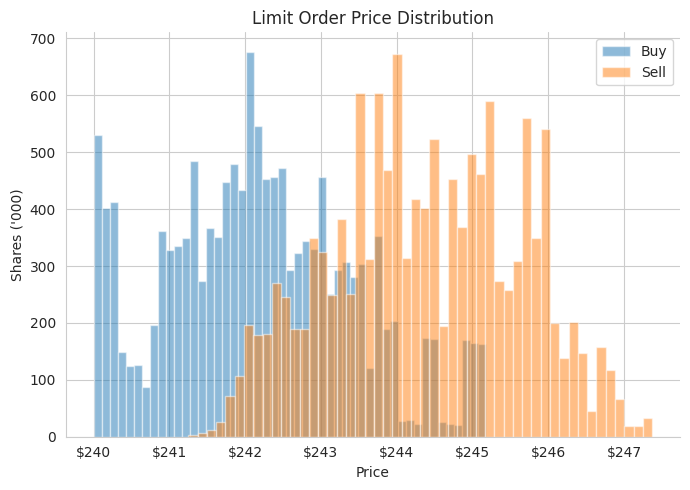

In [ ]:
fig, ax = plt.subplots(figsize=(7,5))
hist_kws = {'linewidth': 1, 'alpha': .5}
sns.distplot(buy[buy.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Buy', kde=False, hist_kws=hist_kws)
sns.distplot(sell[sell.price.between(240, 250)].set_index('timestamp').between_time(market_open, market_close).price, 
             ax=ax, label='Sell', kde=False, hist_kws=hist_kws)

ax.legend(fontsize=10)
ax.set_title('Limit Order Price Distribution')
ax.set_yticklabels([f'{int(y/1000):,}' for y in ax.get_yticks().tolist()])
ax.set_xticklabels([f'${int(x):,}' for x in ax.get_xticks().tolist()])
ax.set_xlabel('Price')
ax.set_ylabel('Shares (\'000)')
sns.despine()
fig.tight_layout();

- **Order Book Depth**

In [ ]:
utc_offset = timedelta(hours=4)
depth = 100

In [ ]:
buy_per_min = (buy
               .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
               .shares
               .sum()
               .apply(np.log)
               .to_frame('shares')
               .reset_index('price')
               .between_time(market_open, market_close)
               .groupby(level='timestamp', as_index=False, group_keys=False)
               .apply(lambda x: x.nlargest(columns='price', n=depth))
               .reset_index())
buy_per_min.timestamp = buy_per_min.timestamp.add(utc_offset).astype(int)
buy_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17600 entries, 0 to 17599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  17600 non-null  int64  
 1   price      17600 non-null  float64
 2   shares     17600 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 412.6 KB


In [ ]:
sell_per_min = (sell
                .groupby([pd.Grouper(key='timestamp', freq='Min'), 'price'])
                .shares
                .sum()
                .apply(np.log)
                .to_frame('shares')
                .reset_index('price')
                .between_time(market_open, market_close)
                .groupby(level='timestamp', as_index=False, group_keys=False)
                .apply(lambda x: x.nsmallest(columns='price', n=depth))
                .reset_index())

sell_per_min.timestamp = sell_per_min.timestamp.add(utc_offset).astype(int)
sell_per_min.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17600 entries, 0 to 17599
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  17600 non-null  int64  
 1   price      17600 non-null  float64
 2   shares     17600 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 412.6 KB


In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store[f'{stock}/trades']
trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0].between_time(market_open, market_close)

trades_per_min = (trades
                  .resample('Min')
                  .agg({'price': 'mean', 'shares': 'sum'}))
trades_per_min.index = trades_per_min.index.to_series().add(utc_offset).astype(int)
trades_per_min.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193 entries, 1572442200000000000 to 1572453720000000000
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   193 non-null    float64
 1   shares  193 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 4.5 KB


The following plots the evolution of limit orders and prices throughout the trading day: the dark line tracks the prices for executed trades during market hours, whereas the red and blue dots indicate individual limit orders on a per-minute basis (see notebook for details)

거래일을 통틀어 지정가 주문과 가격이 어떻게 진화하는가를 그린다. 어두운 선은 장중 체결된 거래에 대한 가격을 추적하고, 빨간 점과 파란 점은 분별 기반의 개별 지정가 주문을 가리킨다.

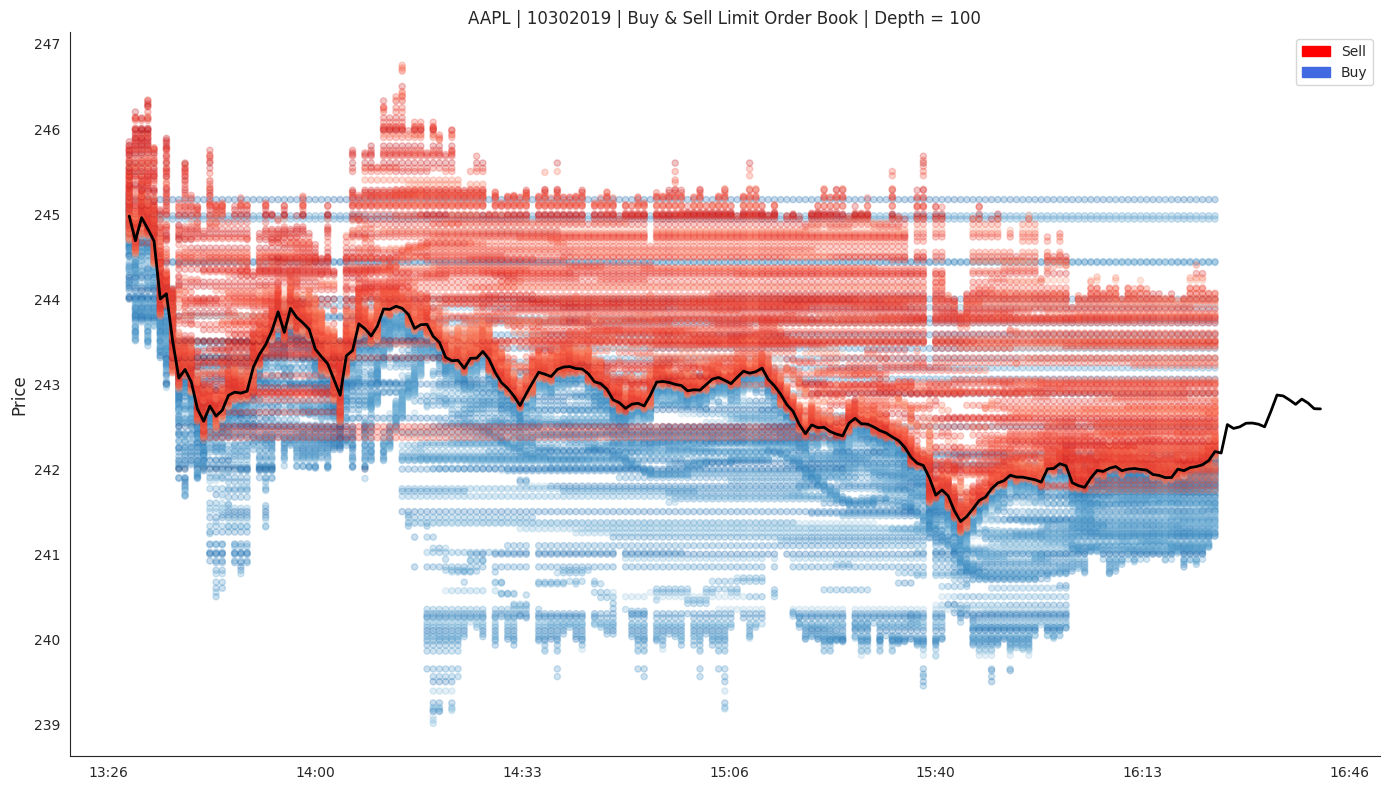

In [ ]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(14, 6))

buy_per_min.plot.scatter(x='timestamp',
                         y='price', 
                         c='shares', 
                         ax=ax, 
                         colormap='Blues', 
                         colorbar=False, 
                         alpha=.25)

sell_per_min.plot.scatter(x='timestamp',
                          y='price', 
                          c='shares', 
                          ax=ax, 
                          colormap='Reds', 
                          colorbar=False, 
                          alpha=.25)

title = f'AAPL | {date} | Buy & Sell Limit Order Book | Depth = {depth}'
trades_per_min.price.plot(figsize=(14, 8), 
                          c='k', 
                          ax=ax, 
                          lw=2, 
                          title=title)

xticks = [datetime.fromtimestamp(ts / 1e9).strftime('%H:%M') for ts in ax.get_xticks()]
ax.set_xticklabels(xticks)

ax.set_xlabel('')
ax.set_ylabel('Price', fontsize=12)

red_patch = mpatches.Patch(color='red', label='Sell')
blue_patch = mpatches.Patch(color='royalblue', label='Buy')

plt.legend(handles=[red_patch, blue_patch])
sns.despine()
fig.tight_layout()

#### 틱에서 바로: 시장 데이터 정규화 방법
거래 데이터는 나노초(nanosecond)에 의해 인덱스되고 불규칙하게 도달하므로 매우 잡음이 많다. 
- 예를 들면 매수-매도 호가 스프레드 반동(bounce)은 거래 개시가 매수와 매도 시장가 주문 사이에 교대로 일어나므로 가격이 매수와 매도 호가 사이에서 진동하게 만든다. 
- 잡음-신호 비율(noise-signal ratio)과 통계적 특성을 개선하고자 거래 활동을 합계해 틱 데이터의 주기를 바꾸고(resample), 정규화한다.

전형적으로 합계된 기간의 시가(첫째), 저가, 고가, 종가(마지막)와 거래량(이들을 결합해 OHLCV로 약칭)과 함께 거래량 가중 평균 가격(VWAP), 거래량과 데이터와 관련된 타임스탬프를 수집한다.



#### 03_normalize_tick_data.ipynb

##### Analyze Order Book Data

##### Imports & Settings

In [ ]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from math import pi
from bokeh.plotting import figure, show
from scipy.stats import normaltest

In [ ]:
%matplotlib inline
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

- 원시 자료: 틱바

다음 코드가 AAPL에 대한 기본 틱 가격과 거래량 데이터의 그래프를 생성한다.

In [ ]:
data_path = Path('data')
itch_store = str(data_path / 'itch.h5')
order_book_store = str(data_path / 'order_book.h5')
stock = 'AAPL'
date = '20191030'
title = '{} | {}'.format(stock, pd.to_datetime(date).date())

##### Load system event data


In [ ]:
with pd.HDFStore(itch_store) as store:
    sys_events = store['S'].set_index('event_code').drop_duplicates()
    sys_events.timestamp = sys_events.timestamp.add(pd.to_datetime(date)).dt.time
    market_open = sys_events.loc['Q', 'timestamp']
    market_close = sys_events.loc['M', 'timestamp']

KeyError: ignored

##### Trade Summary

We will combine the messages that refer to actual trades to learn about the volumes for each asset.

In [ ]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R']
stocks.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26660 entries, 0 to 17772
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype          
---  ------                          --------------  -----          
 0   stock_locate                    26660 non-null  int64          
 1   tracking_number                 26660 non-null  int64          
 2   timestamp                       26660 non-null  timedelta64[ns]
 3   stock                           26660 non-null  object         
 4   market_category                 26660 non-null  object         
 5   financial_status_indicator      26660 non-null  object         
 6   round_lot_size                  26660 non-null  int64          
 7   round_lots_only                 26660 non-null  object         
 8   issue_classification            26660 non-null  object         
 9   issue_sub_type                  26660 non-null  object         
 10  authenticity                    26660 non-null  object    

As expected, a small number of the over 8,500 equity securities traded on this day account for most trades

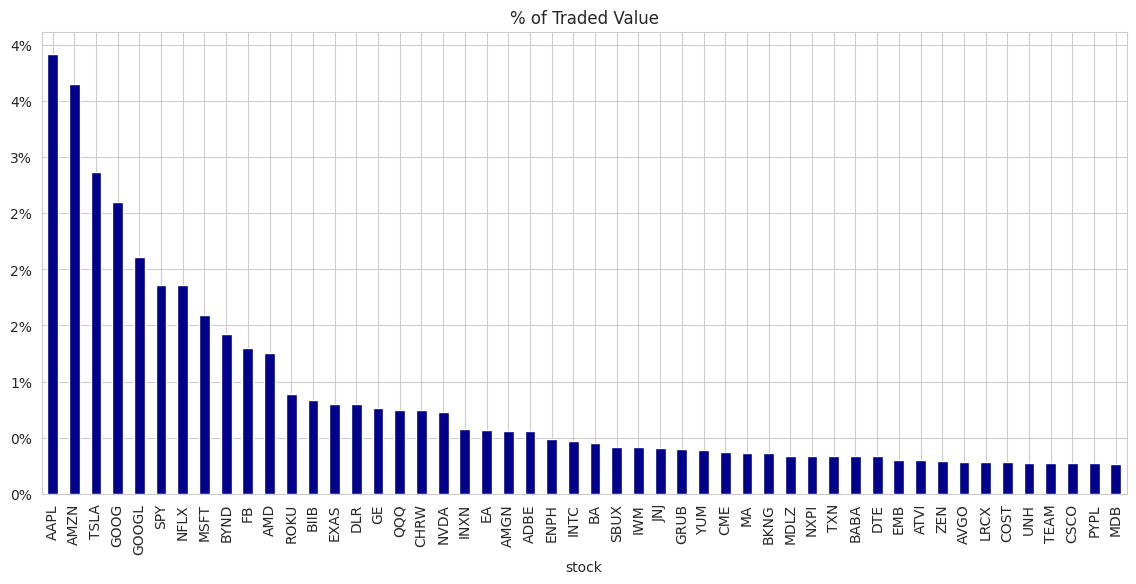

In [ ]:
with pd.HDFStore(itch_store) as store:
    stocks = store['R'].loc[:, ['stock_locate', 'stock']]
    trades = store['P'].append(store['Q'].rename(columns={'cross_price': 'price'}), sort=False).merge(stocks)

trades['value'] = trades.shares.mul(trades.price)    
trades['value_share'] = trades.value.div(trades.value.sum())
trade_summary = trades.groupby('stock').value_share.sum().sort_values(ascending=False)
trade_summary.iloc[:50].plot.bar(figsize=(14, 6), color='darkblue', title='% of Traded Value')
plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

##### AAPL Trade Summary

In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

In [ ]:
trades.price = trades.price.mul(1e-4) # format price
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100226 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 12:42:10.341410167
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   shares  100226 non-null  int64  
 1   price   100226 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


##### Tick Bars

The trade data is indexed by nanoseconds and is very noisy. The bid-ask bounce, for instance, causes the price to oscillate between the bid and ask prices when trade initiation alternates between buy and sell market orders. To improve the noise-signal ratio and improve the statistical properties, we need to resample and regularize the tick data by aggregating the trading activity.

We typically collect the open (first), low, high, and closing (last) price for the aggregated period, alongside the volume-weighted average price (VWAP), the number of shares traded, and the timestamp associated with the data.

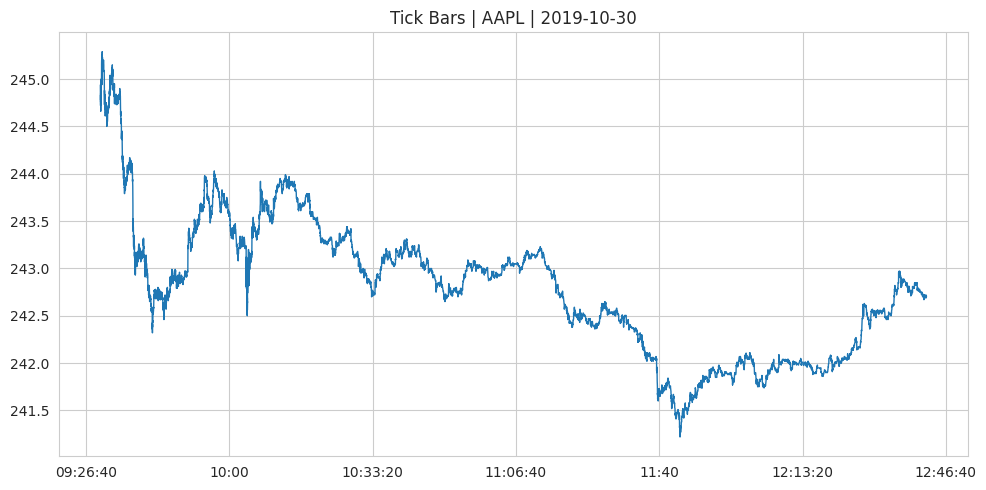

In [ ]:
tick_bars = trades.copy()
tick_bars.index = tick_bars.index.time
tick_bars.price.plot(figsize=(10, 5), 
                     title='Tick Bars | {} | {}'.format(stock, pd.to_datetime(date).date()), lw=1)
plt.xlabel('')
plt.tight_layout();

###### Test for Normality of tick returns

- 낮은 p-value 값으로 알 수 있듯이 틱 수익률은 정규 분포와 많이 다르다.

In [ ]:
normaltest(tick_bars.price.pct_change().dropna())

NormaltestResult(statistic=40196.81734575012, pvalue=0.0)

##### Regularizing Tick Data

###### Price-Volume Chart

We will use the `price_volume` function to compare the price-volume relation for various regularization methods.

In [ ]:
def price_volume(df, price='vwap', vol='vol', suptitle=title, fname=None):
    
    fig, axes = plt.subplots(nrows=2, sharex=True, figsize=(15,8))
    axes[0].plot(df.index, df[price])
    axes[1].bar(df.index, df[vol], width=1/(5*len(df.index)), color='r')
    
    # formatting
    xfmt = mpl.dates.DateFormatter('%H:%M')
    axes[1].xaxis.set_major_locator(mpl.dates.HourLocator(interval=3))
    axes[1].xaxis.set_major_formatter(xfmt)
    axes[1].get_xaxis().set_tick_params(which='major', pad=25)
    axes[0].set_title('Price', fontsize=14)
    axes[1].set_title('Volume', fontsize=14)
    fig.autofmt_xdate()
    fig.suptitle(suptitle)
    fig.tight_layout()
    plt.subplots_adjust(top=0.9);

###### Time Bars

Time bars involve trade aggregation by period.
- 플레인 바닐라 잡은 제거: 시간 바
시간 바는 거래를 기간별로 합계한 것이다. 다음 코드로 시간 바에 대한 데이터를 얻는다.

In [ ]:
def get_bar_stats(agg_trades):
    vwap = agg_trades.apply(lambda x: np.average(x.price, weights=x.shares)).to_frame('vwap')
    ohlc = agg_trades.price.ohlc()
    vol = agg_trades.shares.sum().to_frame('vol')
    txn = agg_trades.shares.size().to_frame('txn')
    return pd.concat([ohlc, vwap, vol, txn], axis=1)

We create time bars using the `.resample()` method with the desired period.

- 가격 거래량 차트

In [ ]:
resampled = trades.groupby(pd.Grouper(freq='1Min'))
time_bars = get_bar_stats(resampled)
normaltest(time_bars.vwap.pct_change().dropna())

NormaltestResult(statistic=46.461595102382866, pvalue=8.14690802426665e-11)

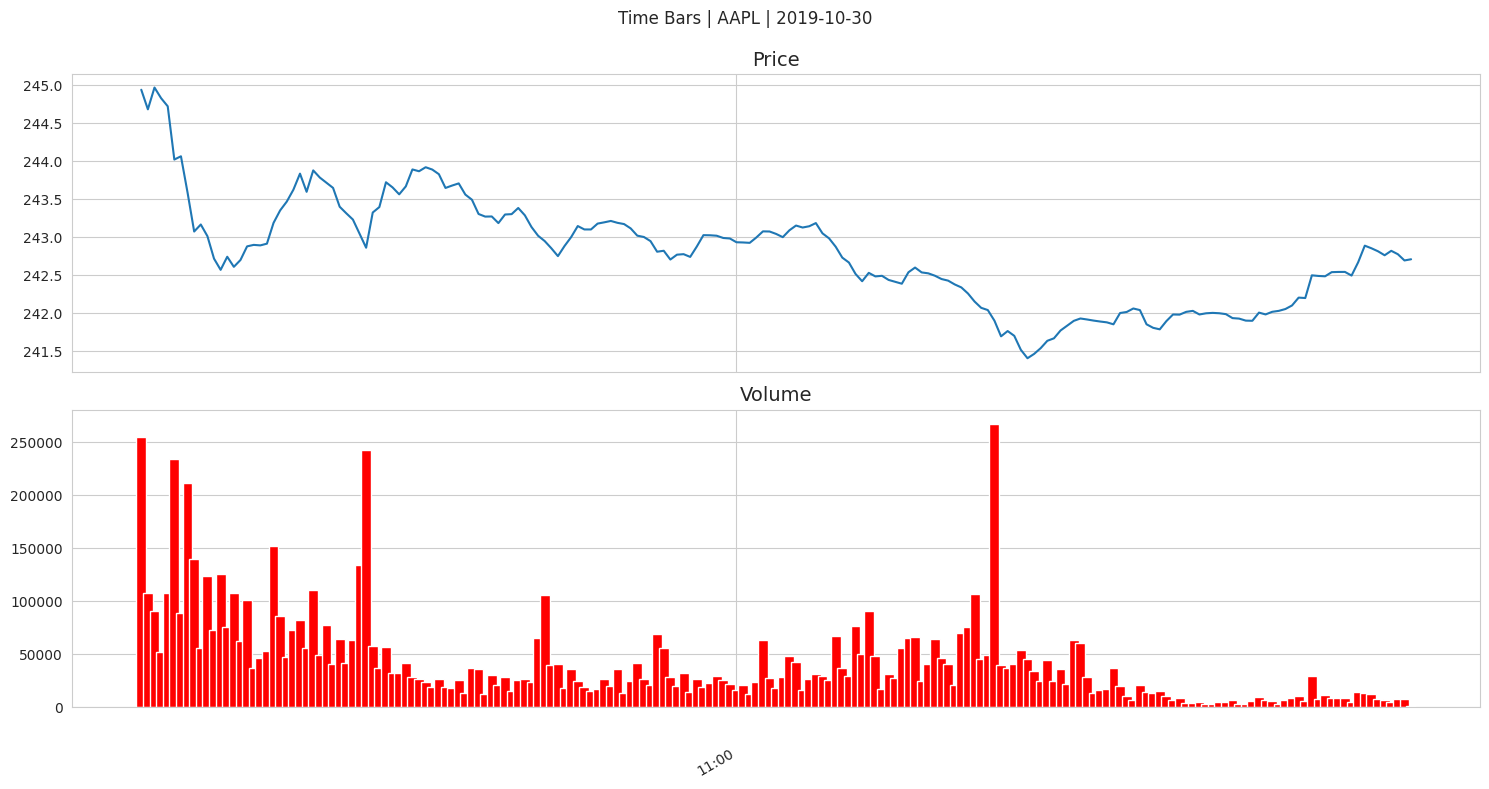

In [ ]:
price_volume(time_bars, 
             suptitle=f'Time Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='time_bars')

###### Bokeh Candlestick Chart

Alternative visualization using the the [bokeh](https://bokeh.pydata.org/en/latest/) library:

- bokeh 그래프 라이브러리를 이용해 데이터를 캔들스틱 차트로 표현

In [ ]:
resampled = trades.groupby(pd.Grouper(freq='5Min')) # 5 Min bars for better print
df = get_bar_stats(resampled)

increase = df.close > df.open
decrease = df.open > df.close
w = 2.5 * 60 * 1000 # 2.5 min in ms

WIDGETS = "pan, wheel_zoom, box_zoom, reset, save"

p = figure(x_axis_type='datetime', tools=WIDGETS, plot_width=1500, title = "AAPL Candlestick")
p.xaxis.major_label_orientation = pi/4
p.grid.grid_line_alpha=0.4

p.segment(df.index, df.high, df.index, df.low, color="black")
p.vbar(df.index[increase], w, df.open[increase], df.close[increase], fill_color="#D5E1DD", line_color="black")
p.vbar(df.index[decrease], w, df.open[decrease], df.close[decrease], fill_color="#F2583E", line_color="black")
show(p)

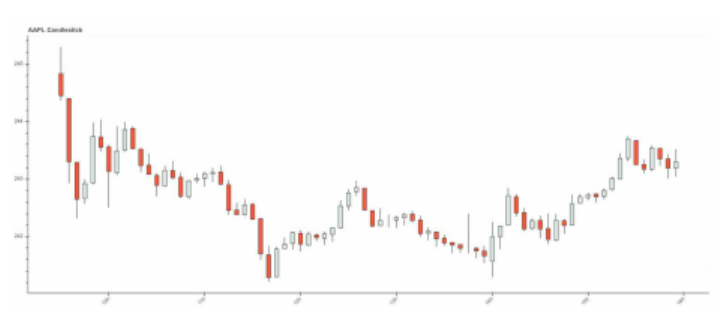

###### Volume Bars
- 주문의 파편화를 고려: 거래량 바

Time bars smooth some of the noise contained in the raw tick data but may fail to account for the fragmentation of orders. Execution-focused algorithmic trading may aim to match the volume weighted average price (VWAP) over a given period, and will divide a single order into multiple trades and place orders according to historical patterns. Time bars would treat the same order differently, even though no new information has arrived in the market.

Volume bars offer an alternative by aggregating trade data according to volume. We can accomplish this as follows:

시간 바는 기본 틱 데이터에 포함된 잡음을 어느 정도 평활화하지만 파편화된 주문을 처리하지 못한다. 체결 중심의 알고리듬 트레이딩은 주어진 기간 동안의 거래량 가중 평균 가격(VWAP)을 매치하는 것이고 목적이고 단일 주문을 여러 개의 주문으로 쪼개 과거의 거래량 패턴에 맞게 주문을 낸다. 

거래량 바는 거래 데이터를 거래량에 맞춰 합계함으로써 대안을 제시한다.

In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100226 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 12:42:10.341410167
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   shares  100226 non-null  int64  
 1   price   100226 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [ ]:
trades_per_min = trades.shares.sum()/(60*7.5) # min per trading day
trades['cumul_vol'] = trades.shares.cumsum()

In [ ]:
df = trades.reset_index()
by_vol = df.groupby(df.cumul_vol.div(trades_per_min).round().astype(int))
vol_bars = pd.concat([by_vol.timestamp.last().to_frame('timestamp'), get_bar_stats(by_vol)], axis=1)
vol_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_vol,,,,,,,,
0,2019-10-30 09:30:00.182683100,244.83,244.94,244.75,244.75,244.77,8236,37
1,2019-10-30 09:30:01.658316623,244.75,244.82,244.72,244.82,244.79,18795,178
2,2019-10-30 09:30:02.124737576,244.82,244.85,244.76,244.77,244.78,16735,121
3,2019-10-30 09:30:02.463948294,244.77,244.80,244.76,244.80,244.77,19116,34
4,2019-10-30 09:30:04.069090088,244.77,244.83,244.66,244.77,244.75,18422,125


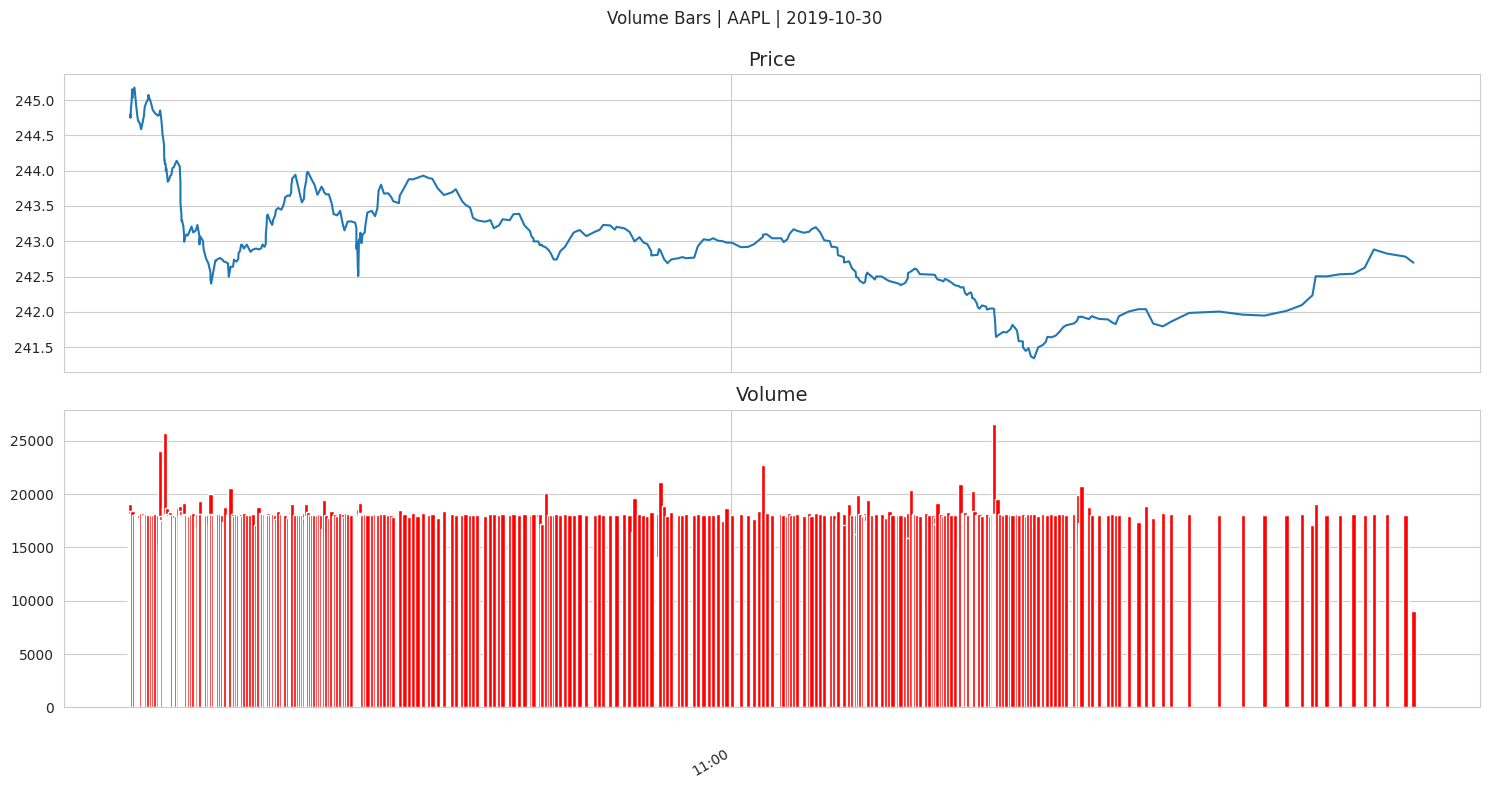

In [ ]:
price_volume(vol_bars.set_index('timestamp'), 
             suptitle=f'Volume Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='volume_bars')

In [ ]:
normaltest(vol_bars.vwap.dropna())

NormaltestResult(statistic=17.54739190888271, pvalue=0.00015475057133158837)

###### Dollar Bars
- 가격 변화를 고려: 거래 금액 바

자산 가격이 크게 변하거나 주식 분할이 일어난 후 주어진 주식수의 가치가 변한다. 거래량 바는 이런 사실을 정확하게 반영하지 못하고 이러한 변화가 일어난 기간 간의 트레이딩 행태를 제대로 비교하지 못하게 한다. 이 경우 거래량 바는 주식 수와 가격의 곱을 이용한 거래 금액 바로 조정돼야 한다.

다음 코드는 거래 금액 바의 계산을 보여준다.

In [ ]:
with pd.HDFStore(order_book_store) as store:
    trades = store['{}/trades'.format(stock)]

trades.price = trades.price.mul(1e-4)
trades = trades[trades.cross == 0]
trades = trades.between_time(market_open, market_close).drop('cross', axis=1)
trades.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100226 entries, 2019-10-30 09:30:00.010384780 to 2019-10-30 12:42:10.341410167
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   shares  100226 non-null  int64  
 1   price   100226 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 2.3 MB


In [ ]:
value_per_min = trades.shares.mul(trades.price).sum()/(60*7.5) # min per trading day
trades['cumul_val'] = trades.shares.mul(trades.price).cumsum()

In [ ]:
df = trades.reset_index()
by_value = df.groupby(df.cumul_val.div(value_per_min).round().astype(int))
dollar_bars = pd.concat([by_value.timestamp.last().to_frame('timestamp'), get_bar_stats(by_value)], axis=1)
dollar_bars.head()

,timestamp,open,high,low,close,vwap,vol,txn
cumul_val,,,,,,,,
0,2019-10-30 09:30:00.182683100,244.83,244.94,244.75,244.75,244.77,8236,37
1,2019-10-30 09:30:01.658316623,244.75,244.82,244.72,244.82,244.79,18295,177
2,2019-10-30 09:30:02.124737576,244.82,244.85,244.76,244.77,244.78,17235,122
3,2019-10-30 09:30:02.463948294,244.77,244.80,244.76,244.80,244.77,19016,33
4,2019-10-30 09:30:04.069090088,244.80,244.82,244.66,244.82,244.75,17778,121


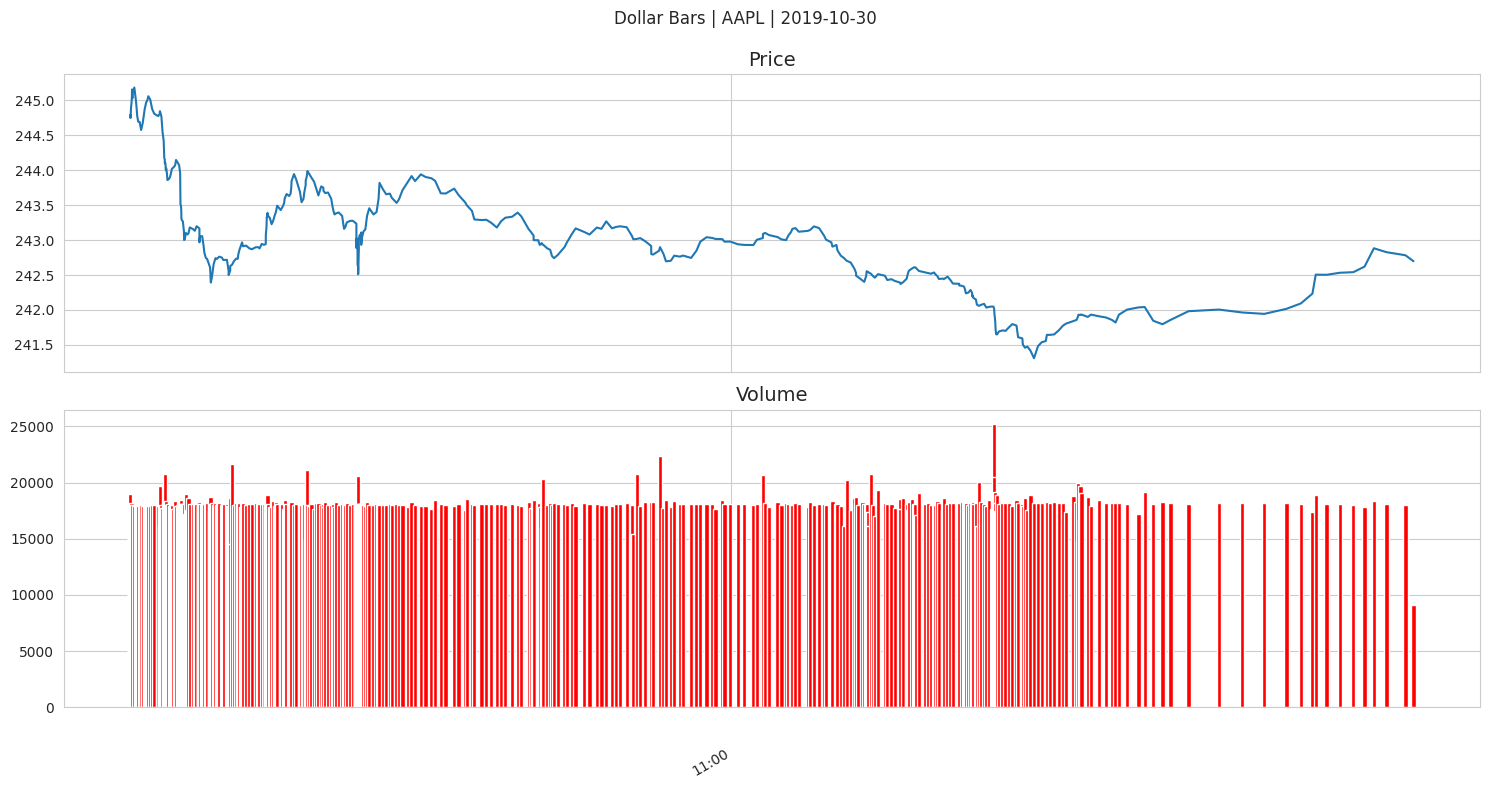

In [ ]:
price_volume(dollar_bars.set_index('timestamp'), 
             suptitle=f'Dollar Bars | {stock} | {pd.to_datetime(date).date()}', 
             fname='dollar_bars')

#### AlgoSeek 분바: 주식 호가와 거래 데이터

AlgoSeek은 기관 투자자에게만 제공됐던 품질의 과거 일별 데이터를 제공한다. AlgoSeek 분 바는 매우 상세한 일중 호가와 거래 데이터를 사용자 친화적 형태로 제공하며, 이는 일상적인 ML 기반 전략에서 쉽게 설계 및 백테스트를 할 수 있게 하기 위한 것이다. 

##### 통합 피드로부터 분 바까지
- AlgoSeek 분 바는 SIP에서 제공하는 데이터를 기반으로 한다.
- SIP는 각 거래소로부터 최상의 매수와 매도 호가를 합계하고, 결과의 거래와 가격을 제공한다. 

- OHLC 바 호가는 MBBO를 기준으로 하며 각 매수나 매도 호가는 MBBO 가격을 의미한다.

##### 호가와 거래 데이터 필드
분바 데이터에는 최대 54개의 필드가 포함된다. 바의 시가, 고가, 저가, 종가 요소에는 8개의 필드가 있다.
- 바와 해당 거래에 대한 타임스탬프
- 현재 매수-매도 호가와 관련 거래에 대한 가격 및 거래 규모


또한 바 기간 동안 거래량 정보가 포함된 14개의 데이터 포인트도 있다.
- 주식수와 해당 거래
- 매수 호가 이하, 매수 호가와 중간 가격, 중간 가격, 중간 가격과 매도 호가 사이, 매도 호가 위에서와 함께 크로스에서의 거래량
- 상승 틱 또는 하락 틱, 즉 가격이 상승 또는 하락했을 때와 가격이 변하지 않을 때의 거래 주식 수로, 이들의 움직임의 이전 방향에 의해 구별된다.


데이터는 바 기간의 거래량 가준평균 가격(VWAP)과 최소 및 최대 매수-매도 호가 스프레드를 포함한다.

##### algoseek_minute_data.ipynb

###### Processing Algoseek's Trade & Quote Minute Bar data
- AlgoSeek 일중 데이터 처리 방법

In this notebook, we load the high-quality NASDAQ100 minute-bar trade-and-quote data generously provided by [Algoseek](https://www.algoseek.com/) (available [here](https://www.algoseek.com/ml4t-book-data.html)) that we will use in [Chapter 12](../../12_gradient_boosting_machines) to develop an intraday trading strategy. 

###### Imports & Settings

In [ ]:
import warnings

warnings.filterwarnings('ignore')

In [ ]:
from pathlib import Path
from tqdm import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
sns.set_style('whitegrid')
idx = pd.IndexSlice

###### Algoseek Trade & Quote Minute Bar Data

- **Data Dictionary**

The Quote fields are based on changes to the NBBO ([National Best Bid Offer](https://www.investopedia.com/terms/n/nbbo.asp)) from the top-of-book price and size from
each of the exchanges.

The enhanced Trade & Quote bar fields include the following fields:
- **Field**: Name of Field.
- **Q / T**: Field based on Quotes or Trades
- **Type**: Field format
- **No Value**: Value of field when there is no value or data. 
  - Note: “Never” means field should always have a value EXCEPT for the first bar of the day.
- **Description**: Description of the field.

| id  | Field                   | Q/T  | Type                          |  No Value | Description                                                                                                                                                                                                         |
|:---:|:------------------------|:----:|:------------------------------|:---------:|:--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1  | `Date`                   |      | YYYYMMDD                      | Never     | Trade Date                                                                                                                                                                                                          |
| 2  | `Ticker`                 |      | String                       | Never      | Ticker Symbol                                                                                                                                                                                                       |
| 3  | `TimeBarStart`           |      | HHMM <br>HHMMSS <br>HHMMSSMMM | Never     | For minute bars: HHMM. <br>For second bars: HHMMSS. <br>Examples<br>- One second bar 130302 is from time greater than 130301 to 130302.<br>- One minute bar 1104 is from time greater than 1103 to 1104. |
| 4  | `OpenBarTime`            | Q    | HHMMSSMMM                    | Never      | Open Time of the Bar, for example one minute:<br>11:03:00.000                                                                                                                                                       |
| 5  | `OpenBidPrice`           | Q    | Number                        | Never     | NBBO Bid Price as of bar Open                                                                                                                                                                                       |
| 6  | `OpenBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with<br>OpenBidPrice                                                                                                                                                                  |
| 7  | `OpenAskPrice`           | Q    | Number                        | Never     | NBBO Ask Price as of bar Open                                                                                                                                                                                       |
| 8  | `OpenAskSize`            | Q    | Number                        | Never     | Total Size from all Exchange with<br>OpenAskPrice                                                                                                                                                                   |
| 9  | `FirstTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of first Trade                                                                                                                                                                                                 |
| 10 | `FirstTradePrice`        | T    | Number                        | Blank     | Price of first Trade                                                                                                                                                                                                |
| 11 | `FirstTradeSize`         | T    | Number                        | Blank     | Number of shares of first trade                                                                                                                                                                                     |
| 12 | `HighBidTime`            | Q    | HHMMSSMMM                     | Never     | Time of highest NBBO Bid Price                                                                                                                                                                                      |
| 13 | `HighBidPrice`           | Q    | Number                        | Never     | Highest NBBO Bid Price                                                                                                                                                                                              |
| 14 | `HighBidSize`            | Q    | Number                        | Never     | Total Size from all Exchanges with HighBidPrice                                                                                                                                                                  |
| 15 | `AskPriceAtHighBidPrice` | Q    | Number                        | Never     | Ask Price at time of Highest Bid Price                                                                                                                                                                              |
| 16 | `AskSizeAtHighBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtHighBidPrice`                                                                                                                                                        |
| 17 | `HighTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of Highest Trade                                                                                                                                                                                               |
| 18 | `HighTradePrice`         | T    | Number                        | Blank     | Price of highest Trade                                                                                                                                                                                              |
| 19 | `HighTradeSize`          | T    | Number                        | Blank     | Number of shares of highest trade                                                                                                                                                                                   |
| 20 | `LowBidTime`             | Q    | HHMMSSMMM                     | Never     | Time of lowest Bid                                                                                                                                                                                                  |
| 21 | `LowBidPrice`            | Q    | Number                        | Never     | Lowest NBBO Bid price of bar.                                                                                                                                                                                       |
| 22 | `LowBidSize`             | Q    | Number                        | Never     | Total Size from all Exchanges with `LowBidPrice`                                                                                                                                                                   |
| 23 | `AskPriceAtLowBidPrice`  | Q    | Number                        | Never     | Ask Price at lowest Bid price                                                                                                                                                                                       |
| 24  | `AskSizeAtLowBidPrice`  | Q    | Number                        | Never     | Total Size from all Exchanges with `AskPriceAtLowBidPrice`                                                                                                                                                                                       |
| 25  | `LowTradeTime`          | T    | HHMMSSMMM                     | Blank     | Time of lowest Trade                                                                                                                                                                                                                             |
| 26  | `LowTradePrice`         | T    | Number                        | Blank     | Price of lowest Trade                                                                                                                                                                                                                            |
| 27  | `LowTradeSize`          | T    | Number                        | Blank     | Number of shares of lowest trade                                                                                                                                                                                                                 |
| 28  | `CloseBarTime`          | Q    | HHMMSSMMM                     | Never     | Close Time of the Bar, for example one minute: 11:03:59.999                                                                                                                                                                                      |
| 29  | `CloseBidPrice`         | Q    | Number                        | Never     | NBBO Bid Price at bar Close                                                                                                                                                                                                                      |
| 30  | `CloseBidSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseBidPrice`                                                                                                                                                                                                |
| 31  | `CloseAskPrice`         | Q    | Number                        | Never     | NBBO Ask Price at bar Close                                                                                                                                                                                                                      |
| 32  | `CloseAskSize`          | Q    | Number                        | Never     | Total Size from all Exchange with `CloseAskPrice`                                                                                                                                                                                                |
| 33  | `LastTradeTime`         | T    | HHMMSSMMM                     | Blank     | Time of last Trade                                                                                                                                                                                                                               |
| 34  | `LastTradePrice`        | T    | Number                        | Blank     | Price of last Trade                                                                                                                                                                                                                              |
| 35  | `LastTradeSize`         | T    | Number                        | Blank     | Number of shares of last trade                                                                                                                                                                                                                   |
| 36  | `MinSpread`             | Q    | Number                        | Never     | Minimum Bid-Ask spread size. This may be 0 if the market was crossed during the bar.<br/>If negative spread due to back quote, make it 0.                                                                                                            |
| 37  | `MaxSpread`             | Q    | Number                        | Never     | Maximum Bid-Ask spread in bar                                                                                                                                                                                                                    |
| 38  | `CancelSize`            | T    | Number                        | 0         | Total shares canceled. Default=blank                                                                                                                                                                                                             |
| 39  | `VolumeWeightPrice`     | T    | Number                        | Blank     | Trade Volume weighted average price <br>Sum((`Trade1Shares`*`Price`)+(`Trade2Shares`*`Price`)+…)/`TotalShares`. <br>Note: Blank if no trades.                                                                                                        |
| 40  | `NBBOQuoteCount`        | Q    | Number                        | 0         | Number of Bid and Ask NNBO quotes during bar period.                                                                                                                                                                                             |
| 41  | `TradeAtBid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or below the bid (a trade reported/printed late can be below current bid).                                                                                                                                  |
| 42  | `TradeAtBidMid`         | Q,T  | Number                        | 0         | Sum of trade volume that occurred between the bid and the mid-point:<br/>(Trade Price > NBBO Bid ) & (Trade Price < NBBO Mid )                                                                                                                       |
| 43  | `TradeAtMid`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at mid.<br/>TradePrice = NBBO MidPoint                                                                                                                                                                             |
| 44  | `TradeAtMidAsk`         | Q,T  | Number                        | 0         | Sum of ask volume that occurred between the mid and ask:<br/>(Trade Price > NBBO Mid) & (Trade Price < NBBO Ask)                                                                                                                                     |
| 45  | `TradeAtAsk`            | Q,T  | Number                        | 0         | Sum of trade volume that occurred at or above the Ask.                                                                                                                                                                                           |
| 46  | `TradeAtCrossOrLocked`  | Q,T  | Number                        | 0         | Sum of trade volume for bar when national best bid/offer is locked or crossed. <br>Locked is Bid = Ask <br>Crossed is Bid > Ask                                                                                                                  |
| 47  | `Volume`                | T    | Number                        | 0         | Total number of shares traded                                                                                                                                                                                                                    |
| 48  | `TotalTrades`           | T    | Number                        | 0         | Total number of trades                                                                                                                                                                                                                           |
| 49  | `FinraVolume`           | T    | Number                        | 0         | Number of shares traded that are reported by FINRA. <br/>Trades reported by FINRA are from broker-dealer internalization, dark pools, Over-The-Counter, etc. <br/>FINRA trades represent volume that is hidden or not public available to trade.         |
| 50  | `UptickVolume`          | T    | Integer                       | 0         | Total number of shares traded with upticks during bar.<br/>An uptick = ( trade price > last trade price )                                                                                                                                                                                                                               |
| 51  | `DowntickVolume`        | T    | Integer                       | 0         | Total number of shares traded with downticks during bar.<br/>A downtick = ( trade price < last trade price )                                                                                                                                                                                                                            |
| 52  | `RepeatUptickVolume`    | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was up during bar. <br/>Repeat uptick = ( trade price == last trade price ) & (last tick direction == up )                                                                                                                                         |
| 53  | `RepeatDowntickVolume`  | T    | Integer                       | 0         | Total number of shares where trade price is the same (repeated) and last price change was down during bar. <br/>Repeat downtick = ( trade price == last trade price ) & (last tick direction == down )                                                                                                                                   |
| 54  | `UnknownVolume`         | T    | Integer                       | 0         | When the first trade of the day takes place, the tick direction is “unknown” as there is no previous Trade to compare it to.<br/>This field is the volume of the first trade after 4am and acts as an initiation value for the tick volume directions.<br/>In future this bar will be renamed to `UnkownTickDirectionVolume` .  |

- **Notes**

**Empty Fields**

An empty field has no value and is “Blank” , for example FirstTradeTime and there are no trades during the bar period. 
The field `Volume` measuring total number of shares traded in bar will be `0` if there are no Trades (see `No Value` column above for each field).

**No Bid/Ask/Trade OHLC**

During a bar timeframe there may not be a change in the NBBO or an actual Trade. 
For example, there can be a bar with OHLC Bid/Ask but no Trade OHLC.

**Single Event**

For bars with only one trade, one NBBO bid or one NBBO ask then Open/High/Low/Close price,size andtime will be the same.

**`AskPriceAtHighBidPrice`, `AskSizeAtHighBidPrice`, `AskPriceAtLowBidPrice`, `AskSizeAtLowBidPrice` Fields** 

To provide consistent Bid/Ask prices at a point in time while showing the low/high Bid/Ask for the bar, AlgoSeek uses the low/high `Bid` and the corresponding `Ask` at that price.

- **FAQ**

**Why are Trade Prices often inside the Bid Price to Ask Price range?**

The Low/High Bid/Ask is the low and high NBBO price for the bar range. 
Very often a Trade may not occur at these prices as the price may only last a few seconds or executions are being crossed at mid-point due to hidden order types that execute at mid-point or as price improvement over current `Bid`/`Ask`.

**How to get exchange tradable shares?** 

To get the exchange tradable volume in a bar subtract `Volume` from `FinraVolume`. 
- `Volume` is the total number of shares traded. 
- ``FinraVolume`` is the total number of shares traded that are reported as executions by FINRA. 

When a trade is done that is off the listed exchanges, it must be reported to FINRA by the brokerage firm or dark pool. Examples include: 
- internal crosses by broker dealer
- over-the-counter block trades, and
- dark pool executions.

###### Data prep

We use the 'Trade and Quote' dataset - see [documentation](https://us-equity-market-data-docs.s3.amazonaws.com/algoseek.US.Equity.TAQ.Minute.Bars.pdf) for details on the definition of the numerous fields.

In [ ]:
tcols = ['openbartime',
         'firsttradetime',
         'highbidtime',
         'highasktime',
         'hightradetime',
         'lowbidtime',
         'lowasktime',
         'lowtradetime',
         'closebartime',
         'lasttradetime']

In [ ]:
drop_cols = ['unknowntickvolume',
             'cancelsize',
             'tradeatcrossorlocked']

In [ ]:
keep = ['firsttradeprice',
        'hightradeprice',
        'lowtradeprice',
        'lasttradeprice',
        'minspread',
        'maxspread',
        'volumeweightprice',
        'nbboquotecount',
        'tradeatbid',
        'tradeatbidmid',
        'tradeatmid',
        'tradeatmidask',
        'tradeatask',
        'volume',
        'totaltrades',
        'finravolume',
        'finravolumeweightprice',
        'uptickvolume',
        'downtickvolume',
        'repeatuptickvolume',
        'repeatdowntickvolume',
        'tradetomidvolweight',
        'tradetomidvolweightrelative']

We will shorten most of the field names to reduce typing:

In [ ]:
columns = {'volumeweightprice': 'price',
           'finravolume': 'fvolume',
           'finravolumeweightprice': 'fprice',
           'uptickvolume': 'up',
           'downtickvolume': 'down',
           'repeatuptickvolume': 'rup',
           'repeatdowntickvolume': 'rdown',
           'firsttradeprice': 'first',
           'hightradeprice': 'high',
           'lowtradeprice': 'low',
           'lasttradeprice': 'last',
           'nbboquotecount': 'nbbo',
           'totaltrades': 'ntrades',
           'openbidprice': 'obprice',
           'openbidsize': 'obsize',
           'openaskprice': 'oaprice',
           'openasksize': 'oasize',
           'highbidprice': 'hbprice',
           'highbidsize': 'hbsize',
           'highaskprice': 'haprice',
           'highasksize': 'hasize',
           'lowbidprice': 'lbprice',
           'lowbidsize': 'lbsize',
           'lowaskprice': 'laprice',
           'lowasksize': 'lasize',
           'closebidprice': 'cbprice',
           'closebidsize': 'cbsize',
           'closeaskprice': 'caprice',
           'closeasksize': 'casize',
           'firsttradesize': 'firstsize',
           'hightradesize': 'highsize',
           'lowtradesize': 'lowsize',
           'lasttradesize': 'lastsize',
           'tradetomidvolweight': 'volweight',
           'tradetomidvolweightrelative': 'volweightrel'}

The Algoseek minute-bar data comes in compressed csv files that contain the data for one symbol and day, organized in three directories for each year (2015-17). The function `extract_and_combine_data` reads the ~80K source files and combines them into a single `hdf5` file for faster access. 

>The data is fairly large (>8GB), and if you run into memory constraints, please modify the code to process the data in smaller chunks. One options is to iterate over the three directories containing data for a single year only, and storing each year separately.

In [ ]:
nasdaq_path = Path('../../data/nasdaq100')

- 거래 전용 분 바 데이터를 일별 .parquet 파일로 추출한다.

In [ ]:
def extract_and_combine_data():
    path = nasdaq_path / '1min_taq'
    if not path.exists():
        path.mkdir(parents=True)

    data = []
    # ~80K files to process
    for f in tqdm(list(path.glob('*/**/*.csv.gz'))):
        data.append(pd.read_csv(f, parse_dates=[['Date', 'TimeBarStart']])
                    .rename(columns=str.lower)
                    .drop(tcols + drop_cols, axis=1)
                    .rename(columns=columns)
                    .set_index('date_timebarstart')
                    .sort_index()
                    .between_time('9:30', '16:00')
                    .set_index('ticker', append=True)
                    .swaplevel()
                    .rename(columns=lambda x: x.replace('tradeat', 'at')))
    data = pd.concat(data).apply(pd.to_numeric, downcast='integer')
    data.index.rename(['ticker', 'date_time'], inplace=True)
    print(data.info(show_counts=True))
    data.to_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [ ]:
extract_and_combine_data()

0it [00:00, ?it/s]


ValueError: ignored

In [ ]:
df = pd.read_hdf(nasdaq_path / 'algoseek.h5', 'min_taq')

In [ ]:
df.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 31355463 entries, ('MSFT', Timestamp('2015-02-09 09:30:00')) to ('DISH', Timestamp('2016-10-11 16:00:00'))
Data columns (total 45 columns):
 #   Column         Non-Null Count     Dtype  
---  ------         --------------     -----  
 0   obprice        31355451 non-null  float64
 1   obsize         31355451 non-null  float64
 2   oaprice        31355457 non-null  float64
 3   oasize         31355457 non-null  float64
 4   first          30955838 non-null  float64
 5   firstsize      30955838 non-null  float64
 6   hbprice        31355463 non-null  float64
 7   hbsize         31355463 non-null  int32  
 8   haprice        31355463 non-null  float64
 9   hasize         31355463 non-null  int32  
 10  high           30955838 non-null  float64
 11  highsize       30955838 non-null  float64
 12  lbprice        31355463 non-null  float64
 13  lbsize         31355463 non-null  int32  
 14  laprice        31355463 non-null  float64
 15  lasize

###### NASDAQ 100 Constituents

The dataset contains 142 stocks because there were multiple changes to index membership over the 2015-17 period:

In [ ]:
len(df.index.unique('ticker'))

142

The below heatmap highlights the frequent entry/exit points of various securities, which emphasizes the need for a survivorship-free dataset.

In [ ]:
constituents = (df.groupby([df.index.get_level_values('date_time').date, 'ticker'])
                .size()
                .unstack('ticker')
                .notnull()
                .astype(int)
                .replace(0, np.nan))

constituents.index = pd.to_datetime(constituents.index)
constituents = constituents.resample('M').max()
constituents.index = constituents.index.date

In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))
mask = constituents.T.isnull()
ax = sns.heatmap(constituents.T, mask=mask, cbar=False, ax=ax, cmap='Blues_r')
ax.set_ylabel('')
fig.suptitle('NASDAQ100 Constituents (2015-2017)')
fig.tight_layout();

## 시장 데이터에 대한 API 접근
파이썬을 이용한 API로 시장 데이터에 접근하는 옵션
- yfinance
- Quantopian(퀀토피안)
- Quendl(퀀들)
- Zipline(집라인)

소스 코드: 03_data_providers 폴더

### 판다스를 이용한 원거리 데이터 접근
판다스 라이브러리는 read_html 함수를 사용해 데이터에 접근할 수 있다. 관련된 pandas-datareader 라이브러리를 통해 다양한 데이터 공급자의 API 단말에 전급할 수 있다.

#### 01_pandas_datareader_demo.ipynb

#### Remote data access using pandas

The pandas library enables access to data displayed on websites using the `read_html()` function and access to the API endpoints of various data providers through the related `pandas-datareader` library.

##### Imports & Settings

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install mplfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.1/73.1 kB 4.9 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import os
from datetime import datetime
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import mplfinance as mpf
import seaborn as sns

##### Download html table with SP500 constituents
- HTML 테이블 읽기
하나 이상의 HTML 테이블을 예로 들면 위키피디아에서 S&P 500 지수의 구성 종목에 대해 다음과 같이 다운로드 할 수 있다.

The download of the content of one or more html tables works as follows, for instance for the constituents of the S&P500 index from Wikipedia

In [5]:
sp_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
sp500_constituents = pd.read_html(sp_url, header=0)[0]

In [6]:
sp500_constituents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Symbol                 503 non-null    object
 1   Security               503 non-null    object
 2   GICS Sector            503 non-null    object
 3   GICS Sub-Industry      503 non-null    object
 4   Headquarters Location  503 non-null    object
 5   Date added             493 non-null    object
 6   CIK                    503 non-null    int64 
 7   Founded                503 non-null    object
dtypes: int64(1), object(7)
memory usage: 31.6+ KB


In [7]:
sp500_constituents.head()

,Symbol,Security,GICS Sector,GICS Sub-Industry,Headquarters Location,Date added,CIK,Founded
0,MMM,3M,Industrials,Industrial Conglomerates,"Saint Paul, Minnesota",1957-03-04,66740,1902
1,AOS,A. O. Smith,Industrials,Building Products,"Milwaukee, Wisconsin",2017-07-26,91142,1916
2,ABT,Abbott,Health Care,Health Care Equipment,"North Chicago, Illinois",1957-03-04,1800,1888
3,ABBV,AbbVie,Health Care,Pharmaceuticals,"North Chicago, Illinois",2012-12-31,1551152,2013 (1888)
4,ACN,Accenture,Information Technology,IT Consulting & Other Services,"Dublin, Ireland",2011-07-06,1467373,1989


##### pandas-datareader for Market Data
- 시장 데이터 다운로드를 위한 판다스-데이터리더

과거에는 판다스가 데이터 공급자들의 API에 직접 접근할 수 있었으나, 현재는 이 기능이 pandas-datareader 라이브러리로 이동했다.

데이터 접근과 추출은 모든 소스에 대해 야후! 파이낸스의 예시와 유사한 API를 따른다.

`pandas` used to facilitate access to data providers' APIs directly, but this functionality has moved to the related pandas-datareader library. The stability of the APIs varies with provider policies, and as of June 2o18 at version 0.7, the following sources are available

See [documentation](https://pandas-datareader.readthedocs.io/en/latest/); functionality frequently changes as underlying provider APIs evolve.

###### Yahoo Finance

In [20]:
# 패키지가 변경된 것으로 추정
'''start = '2014'
end = datetime(2017, 5, 24)

yahoo= web.DataReader('FB', 'yahoo', start=start, end=end)
yahoo.info()'''

TypeError: ignored

[*********************100%***********************]  1 of 1 completed


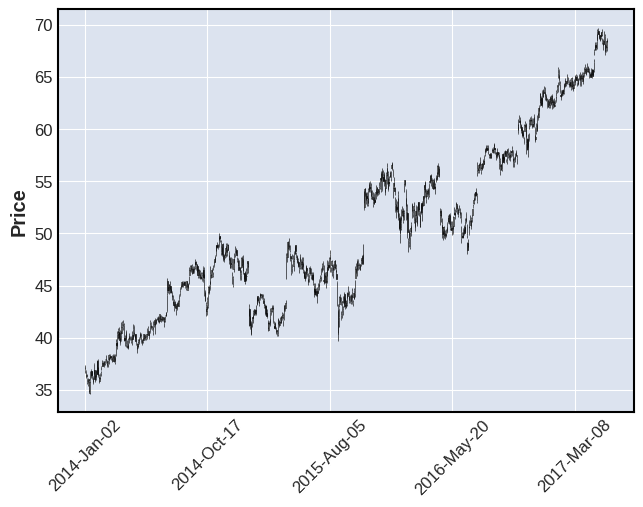

<Figure size 640x480 with 0 Axes>

In [33]:
import yfinance as yf
import mplfinance as mpf

start = datetime(2014, 1, 1)
end = datetime(2017, 5, 24)

yahoo = yf.download('MSFT', start=start, end=end)

if not yahoo.empty:  # 데이터가 비어있지 않은 경우에만 시각화
    yahoo.index = pd.to_datetime(yahoo.index)
    mpf.plot(yahoo.drop('Adj Close', axis=1), type='candle')
    plt.tight_layout()
else:
    print("데이터가 없습니다.")


###### IEX

IEX is an alternative exchange started in response to the HFT controversy and portrayed in Michael Lewis' controversial Flash Boys. It aims to slow down the speed of trading to create a more level playing field and has been growing rapidly since launch in 2016 while still small with a market share of around 2.5% in June 2018.

> **Note:** IEX now requires an [API](https://iexcloud.io/) key after registration for (free) account that you can store as environment variable and retrieve as illustrated below, or pass directly via keyword argument to `pandas_datareader`.

In [ ]:
IEX_API_KEY=os.getenv('IEX_API_KEY')

In [ ]:
start = datetime(2015, 2, 9)
# end = datetime(2017, 5, 24)

iex = web.DataReader('FB', 'iex', start, api_key=IEX_API_KEY)
iex.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1519 entries, 2015-02-09 to 2021-02-19
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    1519 non-null   float64
 1   high    1519 non-null   float64
 2   low     1519 non-null   float64
 3   close   1519 non-null   float64
 4   volume  1519 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 71.2+ KB


In [ ]:
iex.tail()

,open,high,low,close,volume
date,,,,,
2021-02-12,270.520,271.18,268.34,270.50,9097597
2021-02-16,270.800,276.60,270.05,273.97,15417243
2021-02-17,271.240,273.97,269.58,273.57,12763240
2021-02-18,269.565,271.95,266.03,269.39,15249134
2021-02-19,269.860,270.27,260.15,261.56,25622587


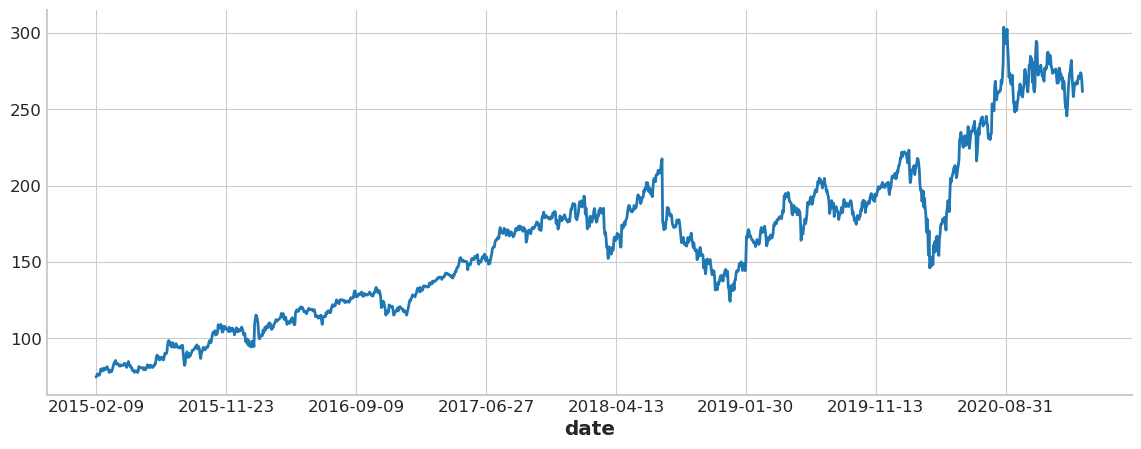

In [ ]:
sns.set_style('whitegrid')
iex.close.plot(figsize=(14, 5))
sns.despine()

- **Book Data**

In addition to historical EOD price and volume data, IEX provides real-time depth of book quotations that offer an aggregated size of orders by price and side. This service also includes last trade price and size information.

DEEP is used to receive real-time depth of book quotations direct from IEX. The depth of book quotations received via DEEP provide an aggregated size of resting displayed orders at a price and side, and do not indicate the size or number of individual orders at any price level. Non-displayed orders and non-displayed portions of reserve orders are not represented in DEEP.

DEEP also provides last trade price and size information. Trades resulting from either displayed or non-displayed orders matching on IEX will be reported. Routed executions will not be reported.

Only works on trading days.

In [ ]:
book = web.get_iex_book('AAPL')

In [ ]:
list(book.keys())

['symbol',
 'marketPercent',
 'volume',
 'lastSalePrice',
 'lastSaleSize',
 'lastSaleTime',
 'lastUpdated',
 'bids',
 'asks',
 'systemEvent',
 'tradingStatus',
 'opHaltStatus',
 'ssrStatus',
 'securityEvent',
 'trades',
 'tradeBreaks']

In [ ]:
orders = pd.concat([pd.DataFrame(book[side]).assign(side=side) for side in ['bids', 'asks']])
orders.head()

,side


In [ ]:
for key in book.keys():
    try:
        print(f'\n{key}')
        print(pd.DataFrame(book[key]))
    except:
        print(book[key])


symbol
AAPL

marketPercent
0.01824

volume
1874997

lastSalePrice
125.98

lastSaleSize
3

lastSaleTime
1614027994379

lastUpdated
1614031191208

bids
Empty DataFrame
Columns: []
Index: []

asks
Empty DataFrame
Columns: []
Index: []

systemEvent
{'systemEvent': 'C', 'timestamp': 1614031800007}

tradingStatus
{'status': 'T', 'reason': '    ', 'timestamp': 1613996038606}

opHaltStatus
{'isHalted': False, 'timestamp': 1613996038606}

ssrStatus
{'isSSR': False, 'detail': ' ', 'timestamp': 1613996038606}

securityEvent
{'securityEvent': 'MarketClose', 'timestamp': 1614027600000}

trades
      price  size     tradeId  isISO  isOddLot  isOutsideRegularHours  \
0   125.980     3  2565301038   True      True                   True   
1   126.010    20  2561192133  False      True                  False   
2   126.010    35  2561162510  False      True                  False   
3   126.005   100  2560819178  False     False                  False   
4   126.005   100  2560535358  False     False

In [ ]:
pd.DataFrame(book['trades']).head()

,price,size,tradeId,isISO,isOddLot,isOutsideRegularHours,isSinglePriceCross,isTradeThroughExempt,timestamp
0,125.980,3,2565301038,True,True,True,False,False,1614027994379
1,126.010,20,2561192133,False,True,False,False,False,1614027597753
2,126.010,35,2561162510,False,True,False,False,False,1614027597658
3,126.005,100,2560819178,False,False,False,False,False,1614027596970
4,126.005,100,2560535358,False,False,False,False,False,1614027596307


###### Quandl

Obtain Quandl [API Key](https://www.quandl.com/tools/api) and store in environment variable as `QUANDL_API_KEY`.

In [ ]:
symbol = 'FB.US'

quandl = web.DataReader(symbol, 'quandl', '2015-01-01')
quandl.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 813 entries, 2018-03-27 to 2015-01-02
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        813 non-null    float64
 1   High        813 non-null    float64
 2   Low         813 non-null    float64
 3   Close       813 non-null    float64
 4   Volume      813 non-null    float64
 5   ExDividend  813 non-null    float64
 6   SplitRatio  813 non-null    float64
 7   AdjOpen     813 non-null    float64
 8   AdjHigh     813 non-null    float64
 9   AdjLow      813 non-null    float64
 10  AdjClose    813 non-null    float64
 11  AdjVolume   813 non-null    float64
dtypes: float64(12)
memory usage: 82.6 KB


###### FRED

In [35]:
start = datetime(2010, 1, 1)

end = datetime(2013, 1, 27)

gdp = web.DataReader('GDP', 'fred', start, end)

gdp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 13 entries, 2010-01-01 to 2013-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GDP     13 non-null     float64
dtypes: float64(1)
memory usage: 208.0 bytes


In [36]:
inflation = web.DataReader(['CPIAUCSL', 'CPILFESL'], 'fred', start, end)
inflation.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37 entries, 2010-01-01 to 2013-01-01
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   CPIAUCSL  37 non-null     float64
 1   CPILFESL  37 non-null     float64
dtypes: float64(2)
memory usage: 888.0 bytes


###### Fama/French

In [37]:
from pandas_datareader.famafrench import get_available_datasets
get_available_datasets()

['F-F_Research_Data_Factors',
 'F-F_Research_Data_Factors_weekly',
 'F-F_Research_Data_Factors_daily',
 'F-F_Research_Data_5_Factors_2x3',
 'F-F_Research_Data_5_Factors_2x3_daily',
 'Portfolios_Formed_on_ME',
 'Portfolios_Formed_on_ME_Wout_Div',
 'Portfolios_Formed_on_ME_Daily',
 'Portfolios_Formed_on_BE-ME',
 'Portfolios_Formed_on_BE-ME_Wout_Div',
 'Portfolios_Formed_on_BE-ME_Daily',
 'Portfolios_Formed_on_OP',
 'Portfolios_Formed_on_OP_Wout_Div',
 'Portfolios_Formed_on_OP_Daily',
 'Portfolios_Formed_on_INV',
 'Portfolios_Formed_on_INV_Wout_Div',
 'Portfolios_Formed_on_INV_Daily',
 '6_Portfolios_2x3',
 '6_Portfolios_2x3_Wout_Div',
 '6_Portfolios_2x3_weekly',
 '6_Portfolios_2x3_daily',
 '25_Portfolios_5x5',
 '25_Portfolios_5x5_Wout_Div',
 '25_Portfolios_5x5_Daily',
 '100_Portfolios_10x10',
 '100_Portfolios_10x10_Wout_Div',
 '100_Portfolios_10x10_Daily',
 '6_Portfolios_ME_OP_2x3',
 '6_Portfolios_ME_OP_2x3_Wout_Div',
 '6_Portfolios_ME_OP_2x3_daily',
 '25_Portfolios_ME_OP_5x5',
 '25_Portf

In [38]:
ds = web.DataReader('5_Industry_Portfolios', 'famafrench')
print(ds['DESCR'])

5 Industry Portfolios
---------------------

This file was created by CMPT_IND_RETS using the 202304 CRSP database. It contains value- and equal-weighted returns for 5 industry portfolios. The portfolios are constructed at the end of June. The annual returns are from January to December. Missing data are indicated by -99.99 or -999. Copyright 2023 Kenneth R. French

  0 : Average Value Weighted Returns -- Monthly (59 rows x 5 cols)
  1 : Average Equal Weighted Returns -- Monthly (59 rows x 5 cols)
  2 : Average Value Weighted Returns -- Annual (5 rows x 5 cols)
  3 : Average Equal Weighted Returns -- Annual (5 rows x 5 cols)
  4 : Number of Firms in Portfolios (59 rows x 5 cols)
  5 : Average Firm Size (59 rows x 5 cols)
  6 : Sum of BE / Sum of ME (5 rows x 5 cols)
  7 : Value-Weighted Average of BE/ME (5 rows x 5 cols)


###### World Bank

In [39]:
from pandas_datareader import wb
gdp_variables = wb.search('gdp.*capita.*const')
gdp_variables.head()

,id,name,unit,source,sourceNote,sourceOrganization,topics
691,6.0.GDPpc_constant,"GDP per capita, PPP (constant 2011 internation...",,LAC Equity Lab,GDP per capita based on purchasing power parit...,b'World Development Indicators (World Bank)',Economy & Growth
10634,NY.GDP.PCAP.KD,GDP per capita (constant 2015 US$),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
10636,NY.GDP.PCAP.KN,GDP per capita (constant LCU),,World Development Indicators,GDP per capita is gross domestic product divid...,"b'World Bank national accounts data, and OECD ...",Economy & Growth
10638,NY.GDP.PCAP.PP.KD,"GDP per capita, PPP (constant 2017 internation...",,World Development Indicators,GDP per capita based on purchasing power parit...,"b'International Comparison Program, World Bank...",Economy & Growth
10639,NY.GDP.PCAP.PP.KD.87,"GDP per capita, PPP (constant 1987 internation...",,WDI Database Archives,,b'',


In [40]:
wb_data = wb.download(indicator='NY.GDP.PCAP.KD', 
                      country=['US', 'CA', 'MX'], 
                      start=1990, 
                      end=2019)
wb_data.head()

NY.GDP.PCAP.KD
country year                
Canada  2019    45109.244486
        2018    44917.483728
        2017    44325.488337
        2016    43536.913403
        2015    43596.135537

###### OECD

In [41]:
df = web.DataReader('TUD', 'oecd', start='2010', end='2019')
df[['Japan', 'United States']]

Country,Japan,United States
Frequency,Annual,Annual
Measure,Percentage of employees,Percentage of employees
Time,,
2010-01-01,18.400000,11.4
2011-01-01,19.000000,11.3
2012-01-01,18.000000,10.8
2013-01-01,17.799999,10.8
2014-01-01,17.600000,10.7
2015-01-01,17.400000,10.3
2016-01-01,17.000000,10.1




###### Stooq

Google finance stopped providing common index data download. The Stooq site had this data for download for a while but is currently broken, awaiting release of [fix](https://github.com/pydata/pandas-datareader/issues/594)

In [42]:
index_url = 'https://stooq.com/t/'
ix = pd.read_html(index_url)
len(ix)

ValueError: ignored

In [43]:
sp500_stooq = web.DataReader('^SPX', 'stooq')
sp500_stooq.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2023-06-09 to 2018-06-12
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1258 non-null   float64
 1   High    1258 non-null   float64
 2   Low     1258 non-null   float64
 3   Close   1258 non-null   float64
 4   Volume  1258 non-null   float64
dtypes: float64(5)
memory usage: 59.0 KB


In [44]:
sp500_stooq.head()

,Open,High,Low,Close,Volume
Date,,,,,
2023-06-09,4304.88,4322.62,4291.70,4298.86,2.135458e+09
2023-06-08,4268.69,4298.01,4261.07,4293.93,2.225615e+09
2023-06-07,4285.47,4299.19,4263.96,4267.52,2.720309e+09
2023-06-06,4271.34,4288.33,4263.09,4283.85,2.246423e+09
2023-06-05,4282.99,4299.28,4266.82,4273.79,2.188379e+09


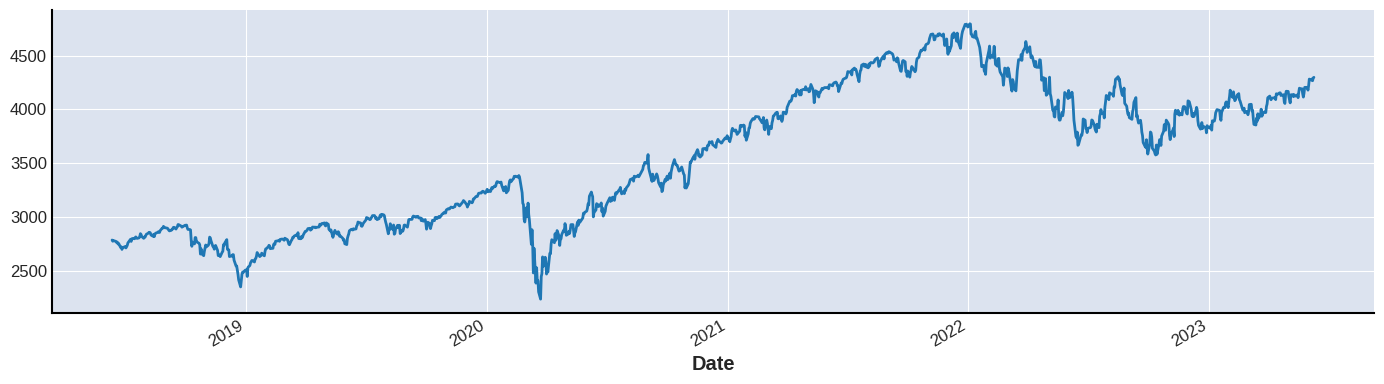

In [45]:
sp500_stooq.Close.plot(figsize=(14,4))
sns.despine()
plt.tight_layout()

###### NASDAQ Symbols

In [46]:
from pandas_datareader.nasdaq_trader import get_nasdaq_symbols
symbols = get_nasdaq_symbols()
symbols.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11421 entries, A to ZYXI
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Nasdaq Traded     11421 non-null  bool    
 1   Security Name     11421 non-null  object  
 2   Listing Exchange  11421 non-null  category
 3   Market Category   11421 non-null  object  
 4   ETF               11421 non-null  bool    
 5   Round Lot Size    11421 non-null  float64 
 6   Test Issue        11421 non-null  bool    
 7   Financial Status  5235 non-null   category
 8   CQS Symbol        6186 non-null   object  
 9   NASDAQ Symbol     11420 non-null  object  
 10  NextShares        11421 non-null  bool    
dtypes: bool(4), category(2), float64(1), object(4)
memory usage: 602.7+ KB


###### Tiingo

Requires [signing up](https://api.tiingo.com/) and storing API key in environment

In [ ]:
df = web.get_data_tiingo('GOOG', api_key=os.getenv('TIINGO_API_KEY'))

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1258 entries, ('GOOG', Timestamp('2016-02-24 00:00:00+0000', tz='UTC')) to ('GOOG', Timestamp('2021-02-22 00:00:00+0000', tz='UTC'))
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   close        1258 non-null   float64
 1   high         1258 non-null   float64
 2   low          1258 non-null   float64
 3   open         1258 non-null   float64
 4   volume       1258 non-null   int64  
 5   adjClose     1258 non-null   float64
 6   adjHigh      1258 non-null   float64
 7   adjLow       1258 non-null   float64
 8   adjOpen      1258 non-null   float64
 9   adjVolume    1258 non-null   int64  
 10  divCash      1258 non-null   float64
 11  splitFactor  1258 non-null   float64
dtypes: float64(10), int64(2)
memory usage: 164.0+ KB


### yfinance: 데이터를 야후! 파이낸스로부터 스크레이핑

#### 02_yfinance_demo.ipynb

### 퀀토피안
- 책에서 많이 활용되어 API 필요

#### 04_quandl_demo.ipynb

### 집라인

#### 05_zipline_data_demo.ipynb

### 기타 시장 데이터 공급자

#### 03_lobster_itch_data.ipynb

## 기본 데이터 작업 방법
- 기본 데이터: 증권의 가치를 결정하는 경제적 동인과 관련
- 데이터의 성격은 자산군에 달려있음
    - 주식과 기업 크레딧: 기업의 재무 및 산업과 경제 전반 데이터 포함
    - 정부채: 국제 거시 경제 데이터와 외환 포함
    - 상품: 수확 시기의 날씨 데이터와 같은 자산 특화된 수급 결정 팩터 포함

### 재무제표 데이터
- 미국 증권거래위원회(SEC)는 미국 증권 발행 기업, 즉 뮤추얼 펀드를 포함한 상장 기업과 증권은 3개의 분기 재무제표(10-Q 양식)와 1개의 연자 보고서(10-K 양식), 규제를 위한 기타 여러 문서를 제출하도록 함

- SEC는 이런 문서를 에드가(EDGAR) 시스템을 통해 공개
- 가치가 발행 기업의 기업 전망과 재무 건전성에 의존하는 주식과 기업 크레딧 같은 증권의 기본적 분석을 위한 주요 데이터 소스가 됨

#### 자동 처리: XBRL
XBRL은 XML에 기반을 두고 있으며, 보고 요소의 의미를 정희하는 분류법에 의존하며, 전자판 보고서의 해당 정보를 강조하는 태그에 매핑한다.

그중 한 분류는 US GAAP를 기술한다.

다음 데이터 세트는 SEC에 제출된 EX-101 부록에서 추출한 정보를 일렬화한 데이터 형태로 제공한다.
- 데이터는 XBRL 태그가 붙은 재무제표에서 선정된 정보를 반영
- 현재 분기와 년간 재무제표에서의 수치 데이터와 추가 필드(표준 산업 분류, SIC)를 포함

SEC에 보고되는 기본적 데이터를 추적하고 접근하는 여러 가지 통로
- 에드가 공공 배포 서비스(PDS, Public Dissemination Service)의 일부로 채택된 문서의 전자 버전은 수수료를 지불하면 사용 가능
- SEC는 제출된 양식화된 공시 자료를 보여주는 RSS 피드를 10분마다 업데이트
- 자동 처리용 FTP를 통해 모든 제출 문서의 검색이 가능하게 하는 공개된 인덱스가 존재
- 재무제표(와 주석) 데이터 세트는 모든 재무제표와 관련 주석에서 파싱된 XBRL 데이터를 포함

또한 SEC는 SEC.gov를 통해 EDGAR 제출 문서(fillings)를 인터넷으로 검색한 트래픽 정보를 지닌 로그 파일을 공개

##### 기본적 시계열 데이터 작성

- 재무제표와 주석의 데이터 범위는 기본 재무제표(대차대조표, 손익계산서, 현금흐름표, 지분변동 및 종합소득)와 이들 보고서 내의 주석들로부터 추출된 수치 데이터로 구성된다.

##### edgar_xbrl.ipynb

##### Working with filing data from the SEC's EDGAR service

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [50]:
%matplotlib inline

from pathlib import Path
from datetime import date
import json
from io import BytesIO
from zipfile import ZipFile, BadZipFile
from tqdm import tqdm
import requests

import pandas_datareader.data as web
import pandas as pd

from pprint import pprint

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

In [51]:
sns.set_style('whitegrid')

In [52]:
# store data in this directory since we won't use it in other chapters
data_path = Path('data') # perhaps set to external harddrive to accomodate large amount of data
if not data_path.exists():
    data_path.mkdir()

###### Download FS & Notes Data
- 재무제표와 주석 데이터 추출

The following code downloads and extracts all historical filings contained in the [Financial Statement and Notes](https://www.sec.gov/dera/data/financial-statement-and-notes-data-set.html) (FSN) datasets from Q1/2014 through Q3/2020. 

> The SEC has moved to a monthly cadence after Q3/2020; feel free to extend the code by creating the correpsonding file names (see linked website) and download those as well.

**Downloads over 40GB of data!**

In [53]:
SEC_URL = 'https://www.sec.gov/'
FSN_PATH = 'files/dera/data/financial-statement-and-notes-data-sets/'

In [54]:
filing_periods = [(d.year, d.quarter) for d in pd.date_range('2014', '2020-09-30', freq='Q')]
filing_periods

[(2014, 1),
 (2014, 2),
 (2014, 3),
 (2014, 4),
 (2015, 1),
 (2015, 2),
 (2015, 3),
 (2015, 4),
 (2016, 1),
 (2016, 2),
 (2016, 3),
 (2016, 4),
 (2017, 1),
 (2017, 2),
 (2017, 3),
 (2017, 4),
 (2018, 1),
 (2018, 2),
 (2018, 3),
 (2018, 4),
 (2019, 1),
 (2019, 2),
 (2019, 3),
 (2019, 4),
 (2020, 1),
 (2020, 2),
 (2020, 3)]

In [55]:
for yr, qtr in tqdm(filing_periods):
    # set (and create) directory
    path = data_path / f'{yr}_{qtr}' / 'source'
    if not path.exists():
        path.mkdir(parents=True)
    
    # define url and get file
    filing = f'{yr}q{qtr}_notes.zip'
    url = SEC_URL + FSN_PATH + filing
    response = requests.get(url).content
    
    # decompress and save
    try:
        with ZipFile(BytesIO(response)) as zip_file:
            for file in zip_file.namelist():
                local_file = path / file
                if local_file.exists():
                    continue
                with local_file.open('wb') as output:
                    for line in zip_file.open(file).readlines():
                        output.write(line)
    except BadZipFile:
        print(f'\nBad zip file: {yr} {qtr}\n')
        continue

 44%|████▍     | 12/27 [08:59<07:58, 31.91s/it]


Bad zip file: 2016 4



100%|██████████| 27/27 [20:35<00:00, 45.75s/it]


###### Save to parquet

The data is fairly large and to enable faster access than the original text files permit, it is better to convert the text files to binary, columnar parquet format (see Section 'Efficient data storage with pandas' in chapter 2 for a performance comparison of various data-storage options compatible with pandas DataFrames):

> Some fo the `txt.tsv` source files contain a small number of faulty lines; the code below drops those lines but indicates the line numbers where you can find the errors if you would like to investigate further. 

매 분기에 대해 FSN 데이터는 제출, 숫자, 분류 태그, 발표 자료 등에 관한 정보를 포함하는 8개의 파일 세트로 정리된다. 각 데이터 세트는 행과 필드로 구성돼 있고 탭 구분 텍스트 파일로 제공된다.

In [56]:
for f in tqdm(sorted(list(data_path.glob('**/*.tsv')))):
    # set (and create) directory
    parquet_path = f.parent.parent / 'parquet'
    if not parquet_path.exists():
        parquet_path.mkdir(parents=True)    

    # write content to .parquet
    file_name = f.stem  + '.parquet'
    if not (parquet_path / file_name).exists():
        try:
            df = pd.read_csv(f, sep='\t', encoding='latin1', low_memory=False, error_bad_lines=False)
            df.to_parquet(parquet_path / file_name)
        except Exception as e:
            print(e, ' | ', f)
        # optional: uncomment to delete original .tsv
#         else:
            # f.unlink

  3%|▎         | 7/208 [01:13<27:50,  8.31s/it]Skipping line 153605: expected 20 fields, saw 22
Skipping line 153606: expected 20 fields, saw 21
Skipping line 316753: expected 20 fields, saw 23
Skipping line 324401: expected 20 fields, saw 28
Skipping line 469248: expected 20 fields, saw 22
Skipping line 509941: expected 20 fields, saw 22

  7%|▋         | 15/208 [02:24<20:18,  6.31s/it]Skipping line 97778: expected 20 fields, saw 21
Skipping line 101028: expected 20 fields, saw 23
Skipping line 154935: expected 20 fields, saw 28
Skipping line 162785: expected 20 fields, saw 23
Skipping line 167447: expected 20 fields, saw 23
Skipping line 193011: expected 20 fields, saw 21
Skipping line 193012: expected 20 fields, saw 21
Skipping line 193013: expected 20 fields, saw 21
Skipping line 193014: expected 20 fields, saw 21
Skipping line 370048: expected 20 fields, saw 21
Skipping line 370049: expected 20 fields, saw 21
Skipping line 370050: expected 20 fields, saw 21

 11%|█         | 23/20

###### Metadata json

In [57]:
file = data_path / '2018_3' / 'source' / '2018q3_notes-metadata.json'
with file.open() as f:
    data = json.load(f)

pprint(data)

{'@context': 'http://www.w3.org/ns/csvw',
 'dialect': {'delimiter': '\t', 'header': True, 'headerRowCount': 1},
 'tables': [{'tableSchema': {'aboutUrl': 'readme.htm',
                             'columns': [{'datatype': {'base': 'string',
                                                       'maxLength': 20,
                                                       'minLength': 20},
                                          'dc:description': 'Accession Number. '
                                                            'The 20-character '
                                                            'string formed '
                                                            'from the 18-digit '
                                                            'number assigned '
                                                            'by the Commission '
                                                            'to each EDGAR '
                                                           

###### Data Organization

For each quarter, the FSN data is organized into eight file sets that contain information about submissions, numbers, taxonomy tags, presentation, and more. Each dataset consists of rows and fields and is provided as a tab-delimited text file:

| 파일  | Dataset      | 설명                                                             |
|------|--------------|------------------------------------------------------------------|
| SUB  | Submission   | 각 회사, 양식, 날짜 등에 따라 XBRL 제출을 식별합니다.                |
| TAG  | Tag          | 각 분류 체계 태그를 정의하고 설명합니다.                            |
| DIM  | Dimension    | 숫자 및 일반 텍스트 데이터에 세부 정보를 추가합니다.               |
| NUM  | Numeric      | 보고서에 있는 각각의 고유한 데이터 지점을 나타냅니다.               |
| TXT  | Plain Text   | 숫자가 아닌 XBRL 필드를 모두 포함합니다.                           |
| REN  | Rendering    | SEC 웹사이트에서 렌더링을 위한 정보를 제공합니다.                    |
| PRE  | Presentation | 기본 보고서에서 태그와 숫자 표시에 대한 자세한 내용입니다.         |
| CAL  | Calculation  | 태그들 간의 산술적 관계를 보여줍니다.                             |


###### Submission Data

The latest submission file contains around 6,500 entries.

In [58]:
sub = pd.read_parquet(data_path / '2018_3' / 'parquet' / 'sub.parquet')
sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 40 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   adsh         6493 non-null   object 
 1   cik          6493 non-null   int64  
 2   name         6493 non-null   object 
 3   sic          6492 non-null   float64
 4   countryba    6482 non-null   object 
 5   stprba       5900 non-null   object 
 6   cityba       6482 non-null   object 
 7   zipba        6478 non-null   object 
 8   bas1         6482 non-null   object 
 9   bas2         2804 non-null   object 
 10  baph         6482 non-null   object 
 11  countryma    6448 non-null   object 
 12  stprma       5906 non-null   object 
 13  cityma       6448 non-null   object 
 14  zipma        6447 non-null   object 
 15  mas1         6448 non-null   object 
 16  mas2         2761 non-null   object 
 17  countryinc   5936 non-null   object 
 18  stprinc      5632 non-null   object 
 19  ein   

- **Get AAPL submission**

The submission dataset contains the unique identifiers required to retrieve the filings: the Central Index Key (CIK) and the Accession Number (adsh). The following shows some of the information about Apple's 2018Q1 10-Q filing:

- 애플 분기 공시 자료 검색

공시 자료 데이터 세트는 제출 문서들을 검색하는 데 필요한 유일한 식별자를 포함한다. 중앙 인덱스 키(CIK)와 접근 숫자(adsh).

다음은 애플의 2018년 1 사분기 10-Q 문서에 대한 일부 정보를 보여준다.

In [59]:
name = 'APPLE INC'
apple = sub[sub.name == name].T.dropna().squeeze()
key_cols = ['name', 'adsh', 'cik', 'name', 'sic', 'countryba', 'stprba',
            'cityba', 'zipba', 'bas1', 'form', 'period', 'fy', 'fp', 'filed']
apple.loc[key_cols]

name                    APPLE INC
adsh         0000320193-18-000100
cik                        320193
name                    APPLE INC
sic                        3571.0
countryba                      US
stprba                         CA
cityba                  CUPERTINO
zipba                       95014
bas1           ONE APPLE PARK WAY
form                         10-Q
period                   20180630
fy                         2018.0
fp                             Q3
filed                    20180801
Name: 1101, dtype: object

###### Build AAPL fundamentals dataset

Using the central index key, we can identify all historical quarterly filings available for Apple, and combine this information to obtain 26 Forms 10-Q and nine annual Forms 10-K.

- **Get filings**

- CIK 키를 사용해서 애플사에 대해 가능한 모든 과거 분기 제출 문서를 알아낼 수 있고, 이 정보를 결합해 26개의 10-Q 문서와 9개의 10-K 문서를 얻을 수 있다.

In [60]:
aapl_subs = pd.DataFrame()
for sub in data_path.glob('**/sub.parquet'):
    sub = pd.read_parquet(sub)
    aapl_sub = sub[(sub.cik.astype(int) == apple.cik) & (sub.form.isin(['10-Q', '10-K']))]
    aapl_subs = pd.concat([aapl_subs, aapl_sub])

We find 15 quarterly 10-Q and 4 annual 10-K reports:

In [61]:
aapl_subs.form.value_counts()

10-Q    21
10-K     5
Name: form, dtype: int64

- **Get numerical filing data**

With the Accession Number for each filing, we can now rely on the taxonomies to select the appropriate XBRL tags (listed in the TAG file) from the NUM and TXT files to obtain the numerical or textual/footnote data points of interest.

각 제출 문서의 접근 숫자를 갖고 분류법에 의거해 NUM과 TXT 파일로부터(TAG 파일에 기록된) 적절한 XBRL 태그를 선택할 수 있다.

First, let's extract all numerical data available from the 19 Apple filings:

In [62]:
aapl_nums = pd.DataFrame()
for num in data_path.glob('**/num.parquet'):
    num = pd.read_parquet(num).drop('dimh', axis=1)
    aapl_num = num[num.adsh.isin(aapl_subs.adsh)]
    print(len(aapl_num))
    aapl_nums = pd.concat([aapl_nums, aapl_num])
aapl_nums.ddate = pd.to_datetime(aapl_nums.ddate, format='%Y%m%d')   
aapl_nums.to_parquet(data_path / 'aapl_nums.parquet')

707
952
793
1035
784
682
1028
751
738
1364
942
755
1039
1176
805
1271
961
1345
919
1001
1224
923
951
905
937
1017


In total, the nine years of filing history provide us with over 18,000 numerical values for AAPL.

In [63]:
aapl_nums.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25005 entries, 3662735 to 3331699
Data columns (total 15 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   adsh      25005 non-null  object        
 1   tag       25005 non-null  object        
 2   version   25005 non-null  object        
 3   ddate     25005 non-null  datetime64[ns]
 4   qtrs      25005 non-null  int64         
 5   uom       25005 non-null  object        
 6   iprx      25005 non-null  int64         
 7   value     24943 non-null  float64       
 8   footnote  68 non-null     object        
 9   footlen   25005 non-null  int64         
 10  dimn      25005 non-null  int64         
 11  coreg     0 non-null      object        
 12  durp      25005 non-null  float64       
 13  datp      25005 non-null  float64       
 14  dcml      25005 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(5), object(6)
memory usage: 3.1+ MB


###### Create P/E Ratio from EPS and stock price data
- 주가 이익 비율 시계열 작성

We can select a useful field, such as Earnings per Diluted Share (EPS), that we can combine with market data to calculate the popular Price/Earnings (P/E) valuation ratio.

9년간의 제출 문서는 모두 28,000개의 수치 데이터를 제공한다. 희석 주당이익(EPS)와 같은 유용한 필드를 선택하고 이를 시장 데이터와 결합해 흔히 사용하는 가격 이익 비율(PYE) 가치 비율을 계산할 수 있다. 

In [64]:
stock_split = 7
split_date = pd.to_datetime('20140604')
split_date

Timestamp('2014-06-04 00:00:00')

We do need to take into account, however, that Apple split its stock 7:1 on June 4, 2014, and Adjusted Earnings per Share before the split to make earnings comparable, as illustrated in the following code block:

하지만 애플사가 2014년 6월 4일에 7:1 주식 분할을 시행했다는 사실을 고려해 이익을 주가 데이터에 비교할 수 있도록 이러한 변화를 반영하게 '수정 형태'로 분할 이전의 EPS를 조정할 필요가 있다.

In [65]:
# Filter by tag; keep only values measuring 1 quarter
eps = aapl_nums[(aapl_nums.tag == 'EarningsPerShareDiluted')
                & (aapl_nums.qtrs == 1)].drop('tag', axis=1)

# Keep only most recent data point from each filing
eps = eps.groupby('adsh').apply(lambda x: x.nlargest(n=1, columns=['ddate']))

# Adjust earnings prior to stock split downward
eps.loc[eps.ddate < split_date,'value'] = eps.loc[eps.ddate < split_date, 'value'].div(7)
eps = eps[['ddate', 'value']].set_index('ddate').squeeze().sort_index()
eps = eps.rolling(4,min_periods=4).sum().dropna()

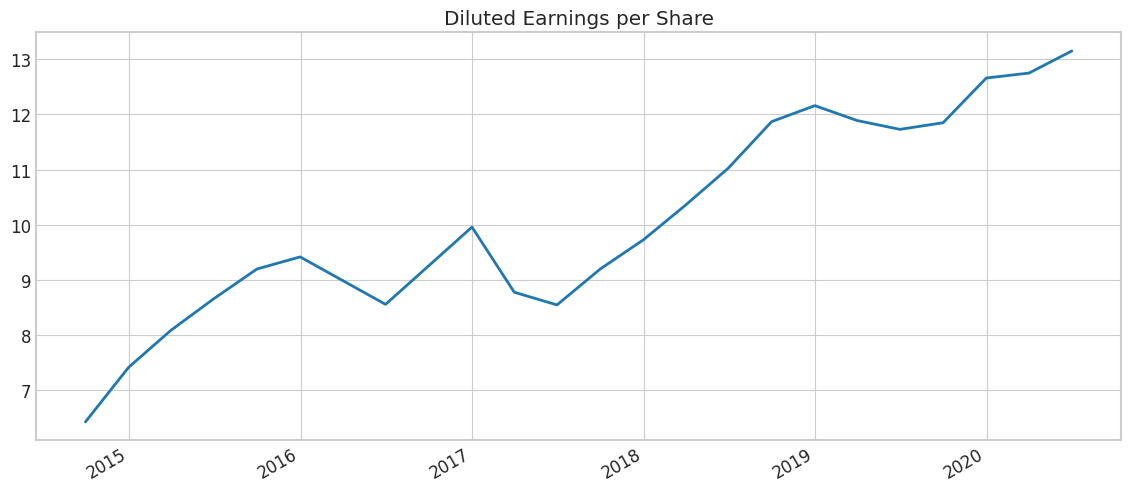

In [67]:
eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps');

TypeError: ignored

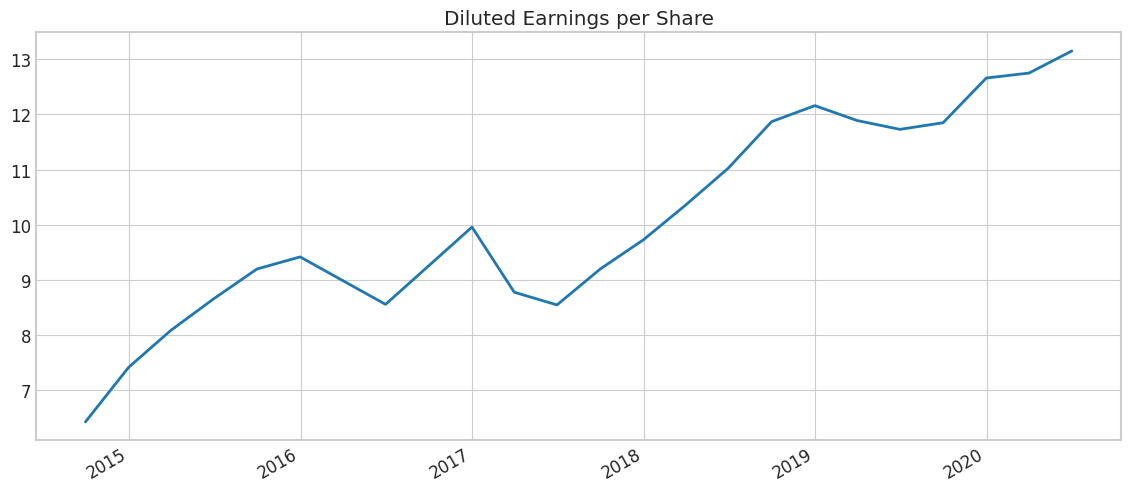

In [66]:
'''eps.plot(lw=2, figsize=(14, 6), title='Diluted Earnings per Share')
plt.xlabel('')
plt.savefig('diluted eps', dps=300);'''

- 퀀들을 이용해 2009년 이후의 애플 주가를 구할 수 있다.

In [73]:
import os
import pandas_datareader as web

# Set the Quandl API key
api_key = 'YOUR_API_KEY'
os.environ['QUANDL_API_KEY'] = api_key

In [74]:
symbol = 'AAPL.US'

aapl_stock = (web.
              DataReader(symbol, 'quandl', start=eps.index.min())
              .resample('D')
              .last()
             .loc['2014':eps.index.max()])
aapl_stock.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Open        877 non-null    float64
 1   High        877 non-null    float64
 2   Low         877 non-null    float64
 3   Close       877 non-null    float64
 4   Volume      877 non-null    float64
 5   ExDividend  877 non-null    float64
 6   SplitRatio  877 non-null    float64
 7   AdjOpen     877 non-null    float64
 8   AdjHigh     877 non-null    float64
 9   AdjLow      877 non-null    float64
 10  AdjClose    877 non-null    float64
 11  AdjVolume   877 non-null    float64
dtypes: float64(12)
memory usage: 129.5 KB


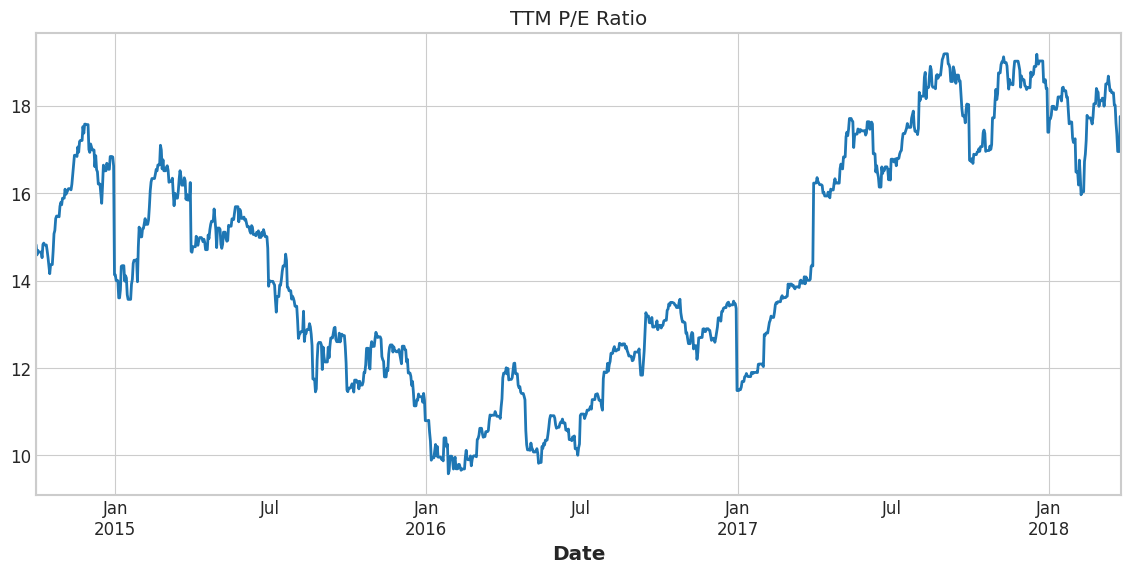

In [75]:
pe = aapl_stock.AdjClose.to_frame('price').join(eps.to_frame('eps'))
pe = pe.fillna(method='ffill').dropna()
pe['P/E Ratio'] = pe.price.div(pe.eps)
pe['P/E Ratio'].plot(lw=2, figsize=(14, 6), title='TTM P/E Ratio');

In [76]:
pe.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2014-09-30 to 2018-03-27
Freq: D
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   price      1275 non-null   float64
 1   eps        1275 non-null   float64
 2   P/E Ratio  1275 non-null   float64
dtypes: float64(3)
memory usage: 72.1 KB


- EDGAR 공시로부터 얻은 최근 12개월 P/E 비율

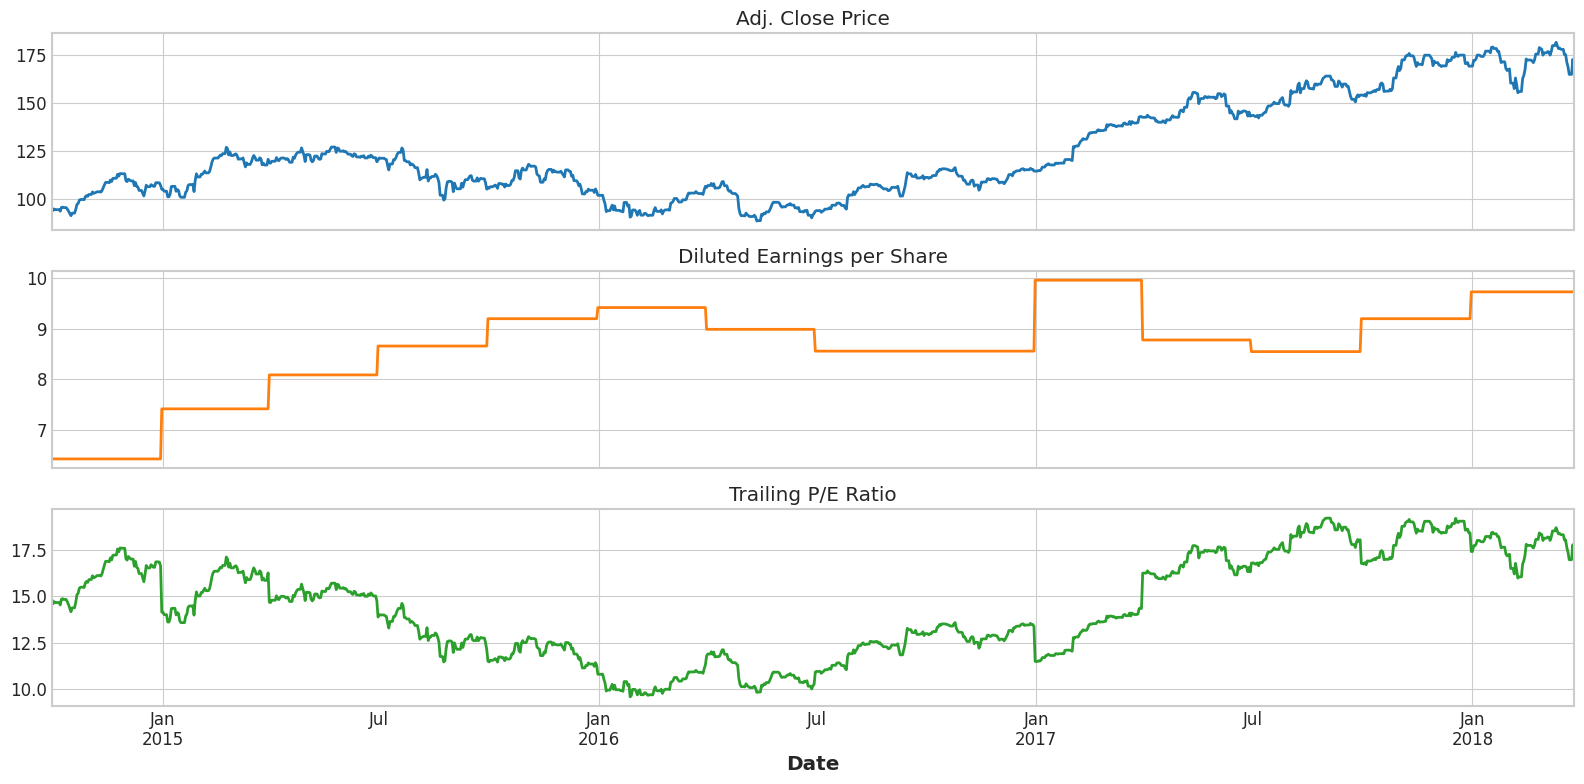

In [77]:
axes = pe.plot(subplots=True, figsize=(16,8), legend=False, lw=2)
axes[0].set_title('Adj. Close Price')
axes[1].set_title('Diluted Earnings per Share')
axes[2].set_title('Trailing P/E Ratio')
plt.tight_layout();

###### Explore Additional Fields

The field `tag` references values defined in the taxonomy:

In [78]:
aapl_nums.tag.value_counts()

CashAndCashEquivalentsAtCarryingValue                                                                         780
DebtInstrumentInterestRateEffectivePercentage                                                                 764
OperatingIncomeLoss                                                                                           629
AvailableForSaleSecuritiesAmortizedCost                                                                       532
AvailableForSaleSecuritiesCurrent                                                                             532
                                                                                                             ... 
ResultOfLegalProceedingsAwardUpHeld                                                                             1
ProceedsFromRepaymentsOfShortTermDebt                                                                           1
ShareBasedCompensationArrangementByShareBasedPaymentAwardOptionsExpectedToVestIntrinsicV

We can select values of interest and track their value or use them as inputs to compute fundamental metrics like the Dividend/Share ratio.

- **Dividends per Share**

In [79]:
fields = ['EarningsPerShareDiluted',
          'PaymentsOfDividendsCommonStock',
          'WeightedAverageNumberOfDilutedSharesOutstanding',
          'OperatingIncomeLoss',
          'NetIncomeLoss',
          'GrossProfit']

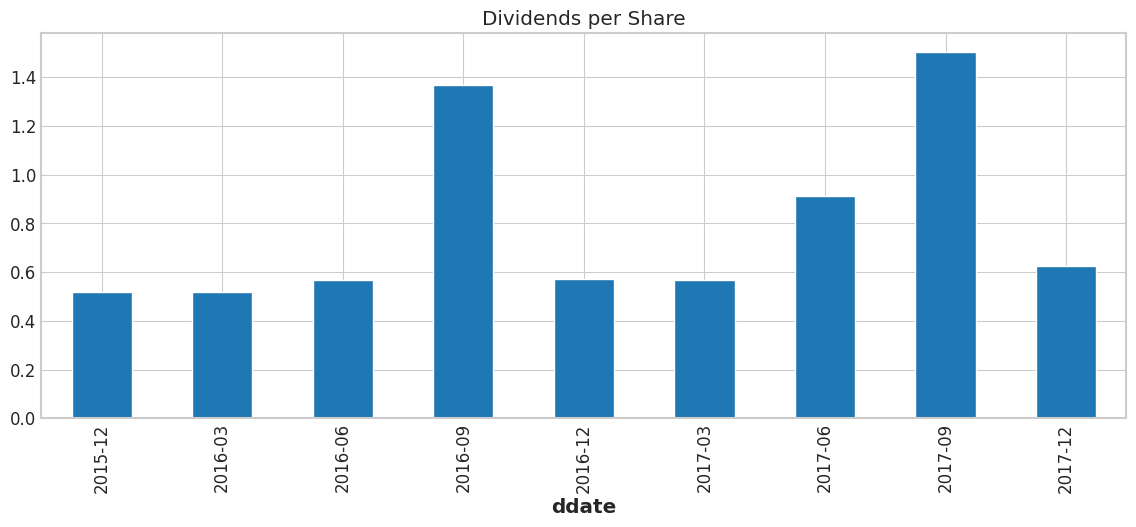

In [80]:
dividends = (aapl_nums
             .loc[aapl_nums.tag == 'PaymentsOfDividendsCommonStock', ['ddate', 'value']]
             .groupby('ddate')
             .mean())
shares = (aapl_nums
          .loc[aapl_nums.tag == 'WeightedAverageNumberOfDilutedSharesOutstanding', ['ddate', 'value']]
          .drop_duplicates()
          .groupby('ddate')
          .mean())
df = dividends.div(shares).dropna()
ax = df.plot.bar(figsize=(14, 5), title='Dividends per Share', legend=False)
ax.xaxis.set_major_formatter(mticker.FixedFormatter(df.index.strftime('%Y-%m')))

###### Bonus: Textual Information

In [81]:
txt = pd.read_parquet(data_path / '2016_2' / 'parquet' /  'txt.parquet')

AAPL's adsh is not avaialble in the txt file but you can obtain notes from the financial statements here:

In [82]:
txt.head()

,adsh,tag,version,ddate,qtrs,iprx,lang,dcml,durp,datp,dimh,dimn,coreg,escaped,srclen,txtlen,footnote,footlen,context,value
0,0000799288-16-000122,AmendmentFlag,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,5,5,None,0,FD2015Q4YTD,false
1,0000799288-16-000122,CurrentFiscalYearEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,7,7,None,0,FD2015Q4YTD,--01-29
2,0000799288-16-000122,DocumentFiscalPeriodFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,2,2,None,0,FD2015Q4YTD,FY
3,0000799288-16-000122,DocumentFiscalYearFocus,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,4,4,None,0,FD2015Q4YTD,2015
4,0000799288-16-000122,DocumentPeriodEndDate,dei/2014,20160131,4,0,en-US,32767,0.021918,2.0,0x00000000,0,None,0,10,10,None,0,FD2015Q4YTD,2016-01-29


## 판다스를 이용한 효율적 데이터 저장
주요 데이터 포맷과 효율성 및 성과 비교
- CSV: 맞춤표 분리, 표준 플랫 텍스트 파일 포맷
- HDF5: 계층적 데이터 포맷으로 수치 데이터에 대해 빠르고 확장할 수 있는 저장 포맷이며, PyTable 라이브러리로 판다스에서 사용
- Parquet: 이진열 저장 포맷으로, 아파치 하둡 에코시스템의 일부. 효율적인 데이터 압축과 인코딩을 제공, pyarrow 라이브러리로 판다스에서 사용

### storage_benchmark.ipynb

#### Storage Benchmark

In this notebook, we'll compare the following storage formats:
- CSV: Comma-separated, standard flat text file format.
- HDF5: Hierarchical data format, developed initially at the National Center for Supercomputing Applications. It is a fast and scalable storage format for numerical data, available in pandas using the PyTables library.
- Parquet: Part of the Apache Hadoop ecosystem, a binary, columnar storage format that provides efficient data compression and encoding and has been developed by Cloudera and Twitter. It is available for pandas through the `pyarrow` library, led by Wes McKinney, the original author of pandas.

This notebook compares the performance of the preceding libraries using a test DataFrame that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table formats. The table format allows for queries and can be appended to.

##### Usage

To recreate the charts used in the book, you need to run this notebook twice up to section 'Store Result' using different settings for `data_type` and arguments for `generate_test_data` as follows:
1. `data_type='Numeric`: `numerical_cols=2000`, `text_cols=0` (default)
2. `data_type='Mixed`: `numerical_cols=1000`, `text_cols=1000`

##### Imports & Settings

In [83]:
import warnings
warnings.filterwarnings('ignore')

In [84]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string

In [85]:
sns.set_style('whitegrid')

In [86]:
results = {}

##### Generate Test Data

The test `DataFrame` that can be configured to contain numerical or text data, or both. For the HDF5 library, we test both the fixed and table format. 

In [87]:
def generate_test_data(nrows=100000, numerical_cols=2000, text_cols=0, text_length=10):
    s = "".join([random.choice(string.ascii_letters)
                 for _ in range(text_length)])
    data = pd.concat([pd.DataFrame(np.random.random(size=(nrows, numerical_cols))),
                      pd.DataFrame(np.full(shape=(nrows, text_cols), fill_value=s))],
                     axis=1, ignore_index=True)
    data.columns = [str(i) for i in data.columns]
    return data

In [88]:
data_type = 'Numeric'

In [89]:
df = generate_test_data(numerical_cols=1000, text_cols=1000)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Columns: 2000 entries, 0 to 1999
dtypes: float64(1000), object(1000)
memory usage: 1.5+ GB


##### Parquet

###### Size

In [90]:
parquet_file = Path('test.parquet')

In [91]:
df.to_parquet(parquet_file)
size = parquet_file.stat().st_size

###### Read

In [92]:
%%timeit -o
df = pd.read_parquet(parquet_file)

4.24 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 4.24 s ± 122 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [93]:
read = _

In [94]:
parquet_file.unlink()

###### Write

In [95]:
%%timeit -o
df.to_parquet(parquet_file)
parquet_file.unlink()

54 s ± 1.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 54 s ± 1.52 s per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [96]:
write = _

###### Results

In [97]:
results['Parquet'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

##### HDF5

In [98]:
test_store = Path('index.h5')

###### Fixed Format

- **Size**

In [99]:
with pd.HDFStore(test_store) as store:
    store.put('file', df)
size = test_store.stat().st_size

- **Read**

In [ ]:
# RAM 25GB 기준 런타임 에러 발생
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.get('file')

In [ ]:
read = _

In [ ]:
test_store.unlink()

- **Write**

In [ ]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.put('file', df)
test_store.unlink()

In [ ]:
write = _

- **Results**

In [ ]:
results['HDF Fixed'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

###### Table Format

- **Size**

In [ ]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
size = test_store.stat().st_size    

- **Read**

In [ ]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    df = store.get('file')

In [ ]:
read = _

In [ ]:
test_store.unlink()

- **Write**

Note that `write` in table format does not work with text data.

In [ ]:
%%timeit -o
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t')
test_store.unlink()    

In [ ]:
write = _

- **Results**

In [ ]:
results['HDF Table'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

###### Table Select

- **Size**

In [ ]:
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
size = test_store.stat().st_size 

- **Read**

In [ ]:
company = 'APPLE INC'

In [ ]:
%%timeit
with pd.HDFStore(test_store) as store:
    s = store.get('file')

In [ ]:
read = _

In [ ]:
test_store.unlink()

- **Write**

In [ ]:
%%timeit
with pd.HDFStore(test_store) as store:
    store.append('file', df, format='t', data_columns=['company', 'form'])
test_store.unlink() 

In [ ]:
write = _

- **Results**

In [ ]:
results['HDF Select'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

##### CSV

In [ ]:
test_csv = Path('test.csv')

###### Size

In [ ]:
df.to_csv(test_csv)
test_csv.stat().st_size

###### Read

In [ ]:
%%timeit -o
df = pd.read_csv(test_csv)

In [ ]:
read = _

In [ ]:
test_csv.unlink()  

###### Write

In [ ]:
%%timeit -o
df.to_csv(test_csv)
test_csv.unlink()

In [ ]:
write = _

###### Results

In [ ]:
results['CSV'] = {'read': np.mean(read.all_runs), 'write': np.mean(write.all_runs), 'size': size}

##### Store Results

In [ ]:
pd.DataFrame(results).assign(Data=data_type).to_csv(f'{data_type}.csv')

##### Display Results

Please run the notebook twice as described above under `Usage` to create the two `csv` files with results for different test data.

In [ ]:
df = (pd.read_csv('Numeric.csv', index_col=0)
      .append(pd.read_csv('Mixed.csv', index_col=0))
      .rename(columns=str.capitalize))
df.index.name='Storage'
df = df.set_index('Data', append=True).unstack()
df.Size /= 1e9

In [ ]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
for i, op in enumerate(['Read', 'Write', 'Size']):
    flag= op in ['Read', 'Write']
    df.loc[:, op].plot.barh(title=op, ax=axes[i], logx=flag)
    if flag:
        axes[i].set_xlabel('seconds (log scale)')
    else:
        axes[i].set_xlabel('GB')
fig.tight_layout()
fig.savefig('storage', dpi=300);

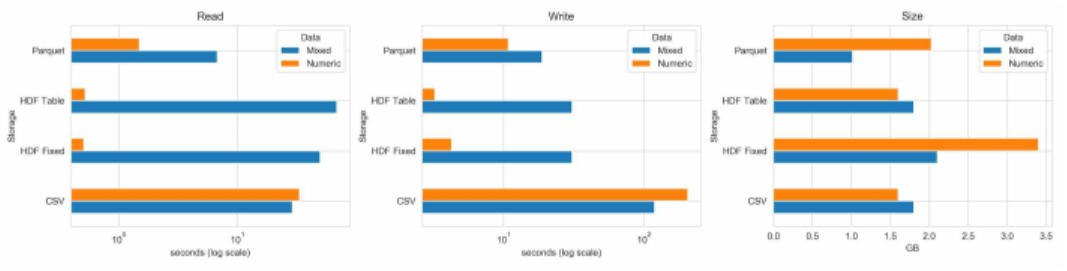